# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [2]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = SeparableConv2DKeras(filters=filters, kernel_size=3, strides=1,
                             padding='same', activation='relu')(input_layer)
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    output = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output = layers.concatenate([output, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [7]:
def fcn_model(inputs, num_classes):
    
    # Input
    # 256 x 256 x 3
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    
    x1 = encoder_block(inputs, 8, 2)
    # 128 x 128 x 8
    x2 = encoder_block(x1, 16, 2)
    # 64 x 64 x 16
    x3 = encoder_block(x2, 32, 2)
    # 32 x 32 x 32
    x4 = encoder_block(x3, 64, 2)
    # 16 x 16 x 64
    x5 = encoder_block(x4, 128, 2)
    # 8 x 8 x 128
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    x6 = conv2d_batchnorm(x5, 256, kernel_size=1, strides=1)
    # 8 x 8 x 256
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x7 = decoder_block(x6, x4, 128)
    # 16 x 16 x 128
    x8 = decoder_block(x7, x3, 64)
    # 32 x 32 x 64
    x9 = decoder_block(x8, x2, 32)
    # 64 x 64 x 32
    x10 = decoder_block(x9, x1, 16)
    # 128 x 128 x 16
    x = decoder_block(x10, inputs, 8)
    # 256 x 256 x 8
      
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
for split in ['train', 'validation']:
    split_dir = '../data/' + split + '/images'
    print('{} has {} images.'.format(split, len(os.listdir(split_dir))))

train has 4131 images.
validation has 1184 images.


In [11]:
from keras.callbacks import *

Using TensorFlow backend.


In [12]:
learning_rate = 0.01
batch_size = 32
num_epochs = 200
steps_per_epoch = 50
validation_steps = 37
workers = 2

In [13]:
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
separable_conv2d_keras_1 (Se (None, 256, 256, 8)       59        
_________________________________________________________________
separable_conv2d_keras_2 (Se (None, 128, 128, 8)       144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
separable_conv2d_keras_3 (Se (None, 128, 128, 16)      216       
_________________________________________________________________
separable_conv2d_keras_4 (Se (None, 64, 64, 16)        416       
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 16)        64        
__________

In [15]:
# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

In [16]:
logger_cb = plotting_tools.LoggerPlotter()
ckpt_cb = ModelCheckpoint('../data/weights/weights.{val_loss:.3f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True)
early_cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=20, verbose=0, mode='auto')
callbacks = [logger_cb, ckpt_cb]

Epoch 1/200
49/50 [============================>.] - ETA: 2s - loss: 0.3537

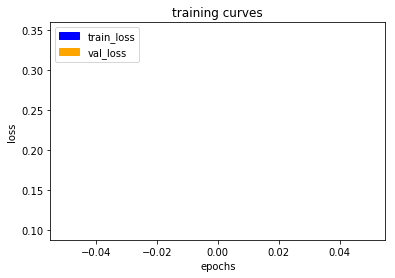

50/50 [==============================] - 127s - loss: 0.3478 - val_loss: 0.1003
Epoch 2/200
49/50 [============================>.] - ETA: 0s - loss: 0.0501

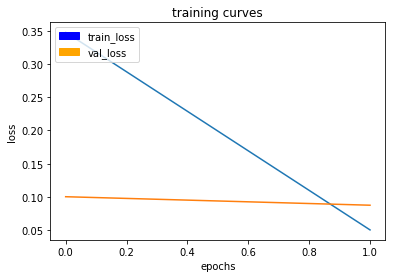

50/50 [==============================] - 41s - loss: 0.0504 - val_loss: 0.0875
Epoch 3/200
49/50 [============================>.] - ETA: 0s - loss: 0.0369

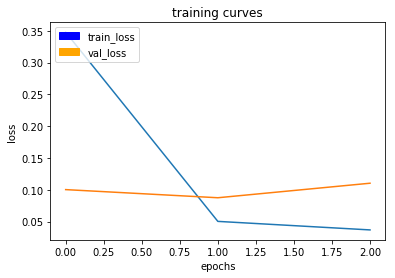

50/50 [==============================] - 40s - loss: 0.0368 - val_loss: 0.1104
Epoch 4/200
49/50 [============================>.] - ETA: 0s - loss: 0.0352

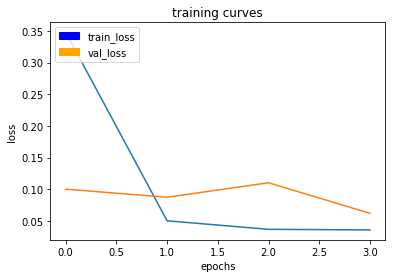

50/50 [==============================] - 41s - loss: 0.0360 - val_loss: 0.0621
Epoch 5/200
49/50 [============================>.] - ETA: 0s - loss: 0.0373

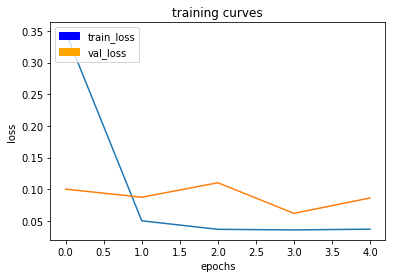

50/50 [==============================] - 41s - loss: 0.0372 - val_loss: 0.0864
Epoch 6/200
49/50 [============================>.] - ETA: 0s - loss: 0.0326

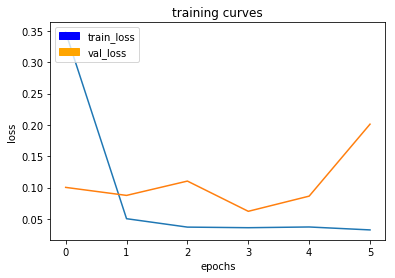

50/50 [==============================] - 40s - loss: 0.0326 - val_loss: 0.2012
Epoch 7/200
49/50 [============================>.] - ETA: 0s - loss: 0.0325

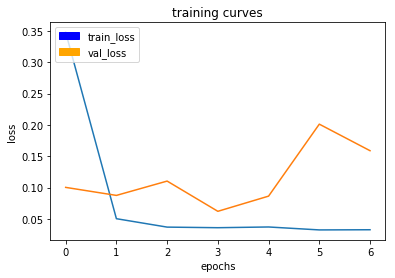

50/50 [==============================] - 40s - loss: 0.0328 - val_loss: 0.1588
Epoch 8/200
49/50 [============================>.] - ETA: 0s - loss: 0.0292

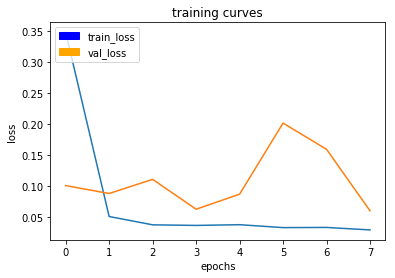

50/50 [==============================] - 40s - loss: 0.0291 - val_loss: 0.0596
Epoch 9/200
49/50 [============================>.] - ETA: 0s - loss: 0.0261

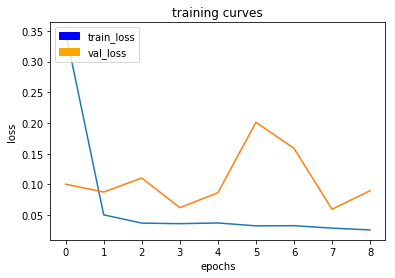

50/50 [==============================] - 41s - loss: 0.0259 - val_loss: 0.0897
Epoch 10/200
49/50 [============================>.] - ETA: 0s - loss: 0.0295

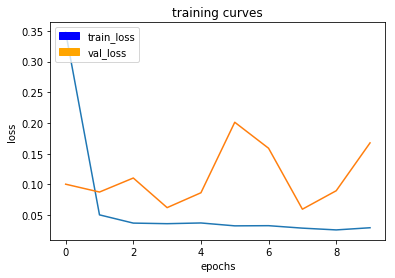

50/50 [==============================] - 41s - loss: 0.0294 - val_loss: 0.1676
Epoch 11/200
49/50 [============================>.] - ETA: 0s - loss: 0.0277

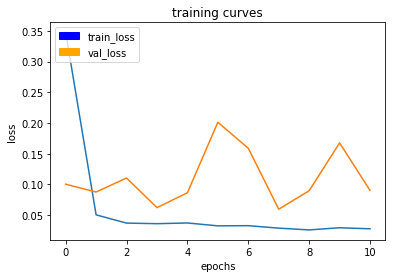

50/50 [==============================] - 40s - loss: 0.0277 - val_loss: 0.0902
Epoch 12/200
49/50 [============================>.] - ETA: 0s - loss: 0.0216

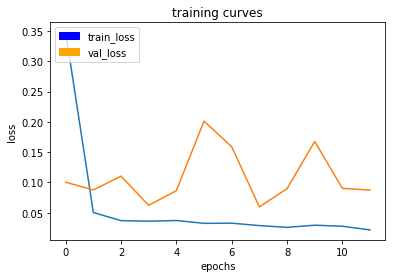

50/50 [==============================] - 41s - loss: 0.0216 - val_loss: 0.0874
Epoch 13/200
49/50 [============================>.] - ETA: 0s - loss: 0.0275

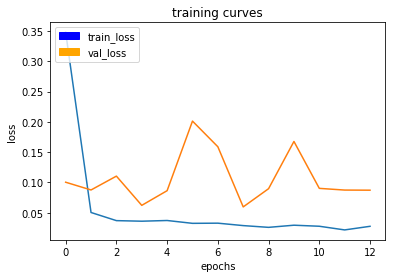

50/50 [==============================] - 40s - loss: 0.0274 - val_loss: 0.0872
Epoch 14/200
49/50 [============================>.] - ETA: 0s - loss: 0.0234

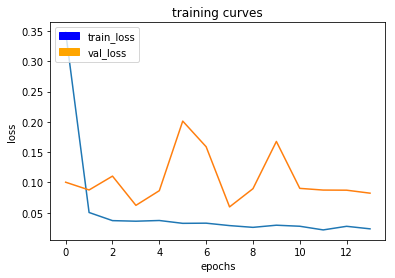

50/50 [==============================] - 40s - loss: 0.0234 - val_loss: 0.0822
Epoch 15/200
49/50 [============================>.] - ETA: 0s - loss: 0.0232

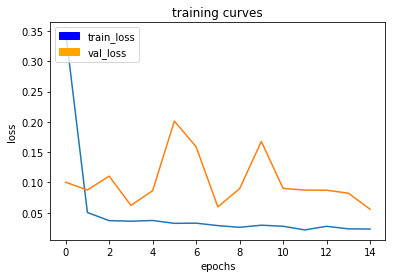

50/50 [==============================] - 41s - loss: 0.0231 - val_loss: 0.0558
Epoch 16/200
49/50 [============================>.] - ETA: 0s - loss: 0.0251

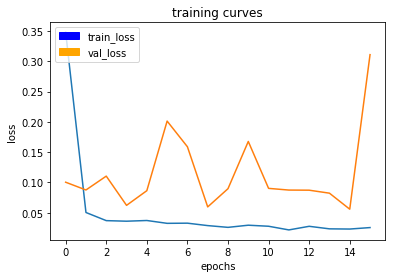

50/50 [==============================] - 40s - loss: 0.0252 - val_loss: 0.3108
Epoch 17/200
49/50 [============================>.] - ETA: 0s - loss: 0.0226

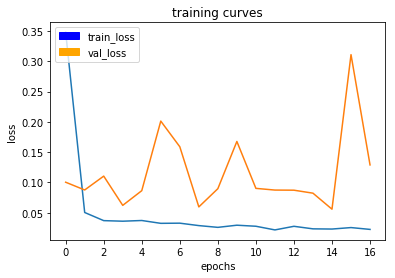

50/50 [==============================] - 41s - loss: 0.0225 - val_loss: 0.1289
Epoch 18/200
49/50 [============================>.] - ETA: 0s - loss: 0.0207

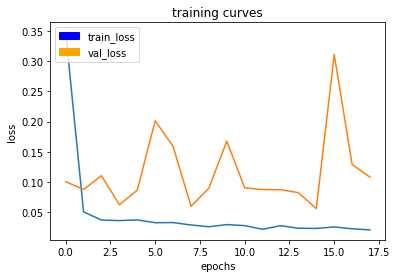

50/50 [==============================] - 41s - loss: 0.0206 - val_loss: 0.1079
Epoch 19/200
49/50 [============================>.] - ETA: 0s - loss: 0.0246

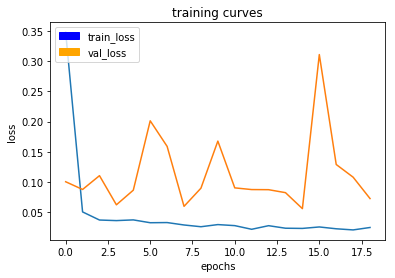

50/50 [==============================] - 40s - loss: 0.0244 - val_loss: 0.0725
Epoch 20/200
49/50 [============================>.] - ETA: 0s - loss: 0.0202

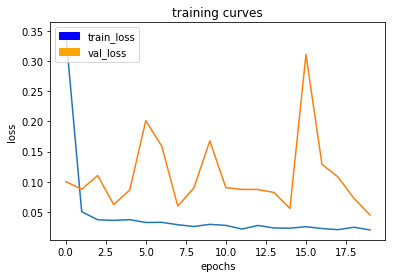

50/50 [==============================] - 41s - loss: 0.0202 - val_loss: 0.0448
Epoch 21/200
49/50 [============================>.] - ETA: 0s - loss: 0.0247

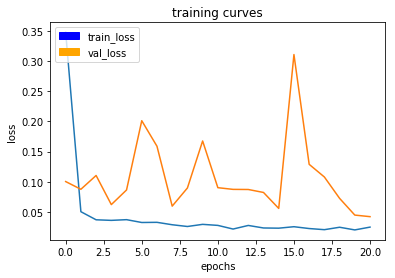

50/50 [==============================] - 40s - loss: 0.0247 - val_loss: 0.0421
Epoch 22/200
49/50 [============================>.] - ETA: 0s - loss: 0.0203

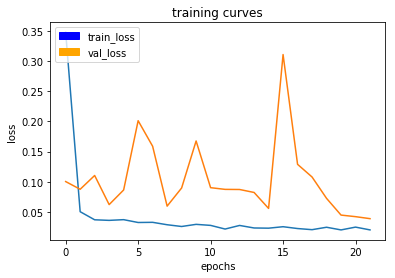

50/50 [==============================] - 41s - loss: 0.0202 - val_loss: 0.0388
Epoch 23/200
49/50 [============================>.] - ETA: 0s - loss: 0.0206

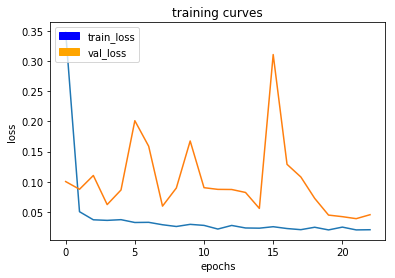

50/50 [==============================] - 40s - loss: 0.0205 - val_loss: 0.0454
Epoch 24/200
49/50 [============================>.] - ETA: 0s - loss: 0.0189

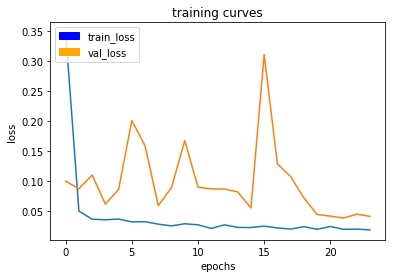

50/50 [==============================] - 40s - loss: 0.0190 - val_loss: 0.0417
Epoch 25/200
49/50 [============================>.] - ETA: 0s - loss: 0.0210

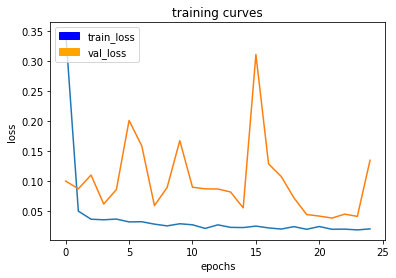

50/50 [==============================] - 40s - loss: 0.0209 - val_loss: 0.1349
Epoch 26/200
49/50 [============================>.] - ETA: 0s - loss: 0.0188

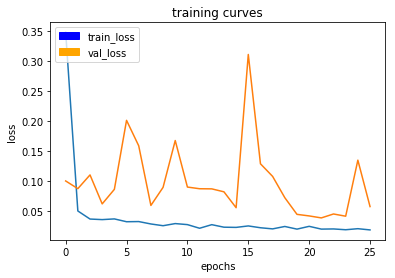

50/50 [==============================] - 40s - loss: 0.0194 - val_loss: 0.0577
Epoch 27/200
49/50 [============================>.] - ETA: 0s - loss: 0.0220

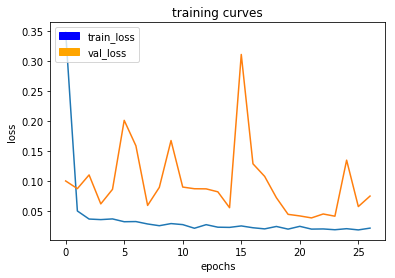

50/50 [==============================] - 40s - loss: 0.0218 - val_loss: 0.0752
Epoch 28/200
49/50 [============================>.] - ETA: 0s - loss: 0.0183

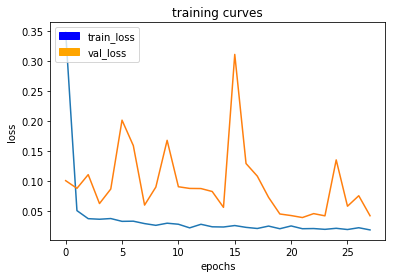

50/50 [==============================] - 41s - loss: 0.0182 - val_loss: 0.0418
Epoch 29/200
49/50 [============================>.] - ETA: 0s - loss: 0.0182

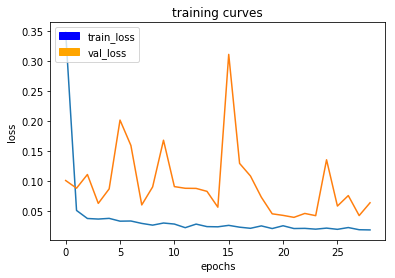

50/50 [==============================] - 40s - loss: 0.0181 - val_loss: 0.0632
Epoch 30/200
49/50 [============================>.] - ETA: 0s - loss: 0.0190

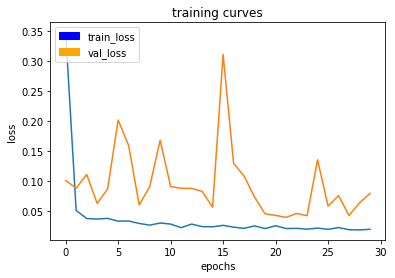

50/50 [==============================] - 40s - loss: 0.0189 - val_loss: 0.0788
Epoch 31/200
49/50 [============================>.] - ETA: 0s - loss: 0.0179

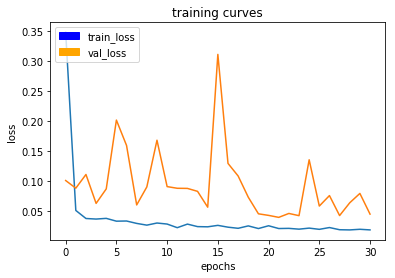

50/50 [==============================] - 40s - loss: 0.0179 - val_loss: 0.0443
Epoch 32/200
49/50 [============================>.] - ETA: 0s - loss: 0.0168

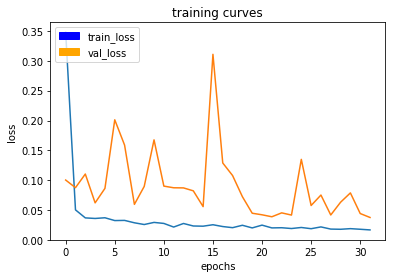

50/50 [==============================] - 40s - loss: 0.0168 - val_loss: 0.0376
Epoch 33/200
49/50 [============================>.] - ETA: 0s - loss: 0.0195

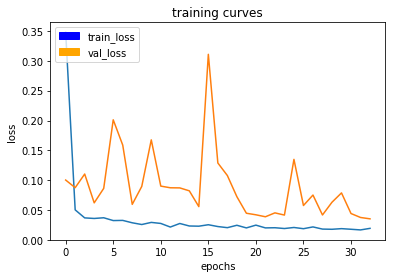

50/50 [==============================] - 41s - loss: 0.0194 - val_loss: 0.0354
Epoch 34/200
49/50 [============================>.] - ETA: 0s - loss: 0.0148

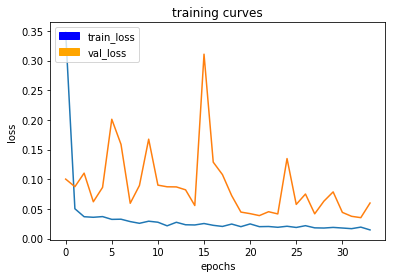

50/50 [==============================] - 40s - loss: 0.0148 - val_loss: 0.0600
Epoch 35/200
49/50 [============================>.] - ETA: 0s - loss: 0.0166

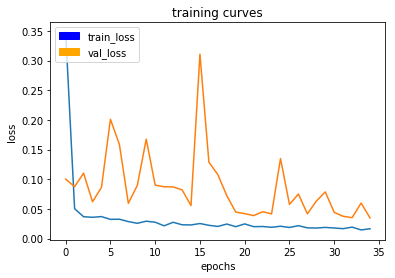

50/50 [==============================] - 41s - loss: 0.0166 - val_loss: 0.0349
Epoch 36/200
49/50 [============================>.] - ETA: 0s - loss: 0.0182

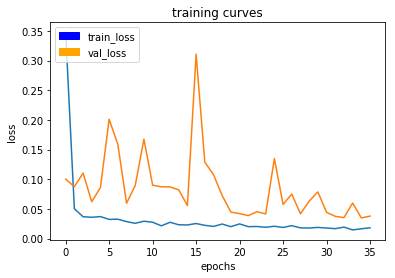

50/50 [==============================] - 40s - loss: 0.0183 - val_loss: 0.0380
Epoch 37/200
49/50 [============================>.] - ETA: 0s - loss: 0.0166

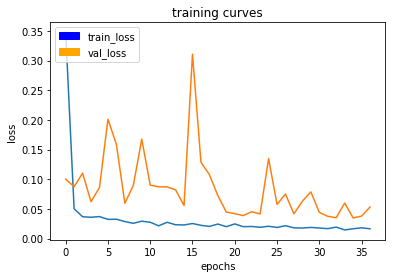

50/50 [==============================] - 40s - loss: 0.0167 - val_loss: 0.0533
Epoch 38/200
49/50 [============================>.] - ETA: 0s - loss: 0.0134

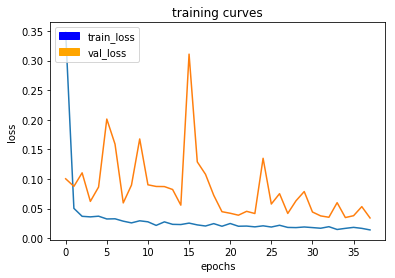

50/50 [==============================] - 41s - loss: 0.0140 - val_loss: 0.0342
Epoch 39/200
49/50 [============================>.] - ETA: 0s - loss: 0.0185

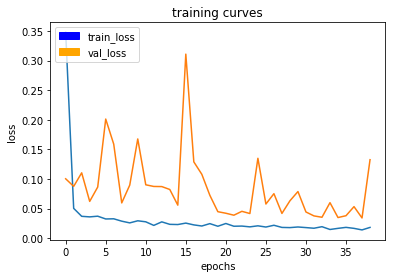

50/50 [==============================] - 40s - loss: 0.0184 - val_loss: 0.1325
Epoch 40/200
49/50 [============================>.] - ETA: 0s - loss: 0.0178

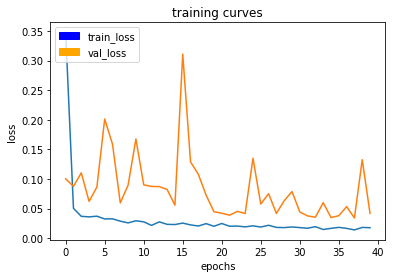

50/50 [==============================] - 40s - loss: 0.0177 - val_loss: 0.0419
Epoch 41/200
49/50 [============================>.] - ETA: 0s - loss: 0.0154

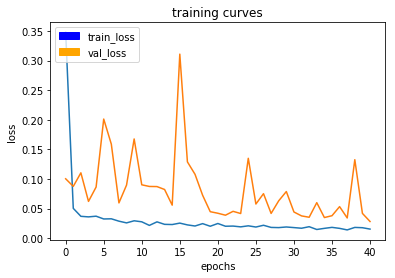

50/50 [==============================] - 41s - loss: 0.0154 - val_loss: 0.0282
Epoch 42/200
49/50 [============================>.] - ETA: 0s - loss: 0.0167

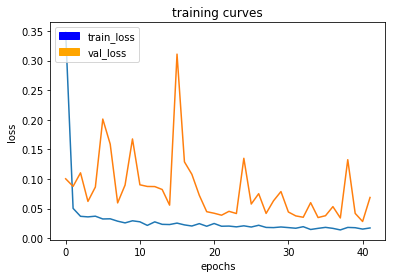

50/50 [==============================] - 40s - loss: 0.0172 - val_loss: 0.0688
Epoch 43/200
49/50 [============================>.] - ETA: 0s - loss: 0.0172

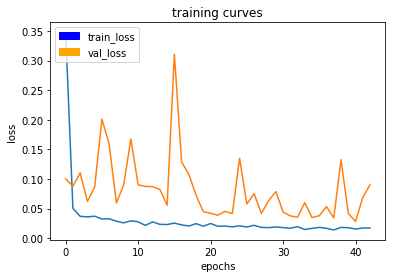

50/50 [==============================] - 40s - loss: 0.0172 - val_loss: 0.0904
Epoch 44/200
49/50 [============================>.] - ETA: 0s - loss: 0.0165

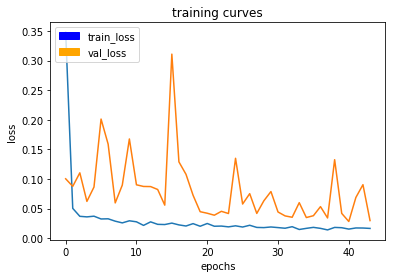

50/50 [==============================] - 40s - loss: 0.0165 - val_loss: 0.0297
Epoch 45/200
49/50 [============================>.] - ETA: 0s - loss: 0.0168

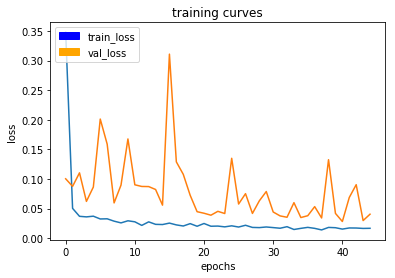

50/50 [==============================] - 40s - loss: 0.0169 - val_loss: 0.0405
Epoch 46/200
49/50 [============================>.] - ETA: 0s - loss: 0.0167

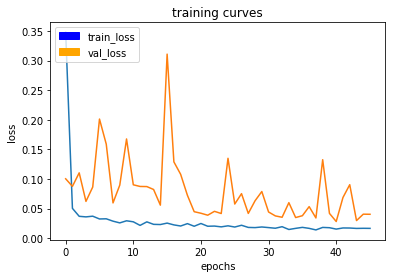

50/50 [==============================] - 41s - loss: 0.0166 - val_loss: 0.0404
Epoch 47/200
49/50 [============================>.] - ETA: 0s - loss: 0.0145

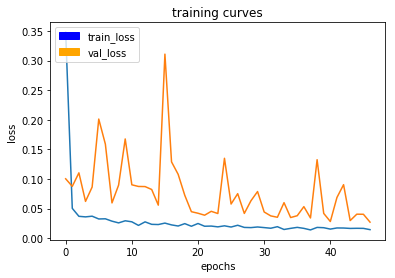

50/50 [==============================] - 40s - loss: 0.0144 - val_loss: 0.0271
Epoch 48/200
49/50 [============================>.] - ETA: 0s - loss: 0.0146

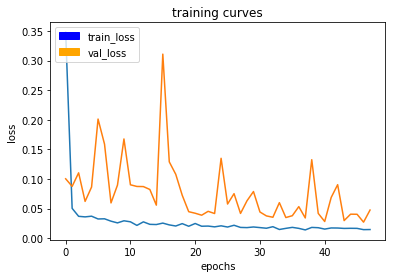

50/50 [==============================] - 40s - loss: 0.0146 - val_loss: 0.0475
Epoch 49/200
49/50 [============================>.] - ETA: 0s - loss: 0.0194

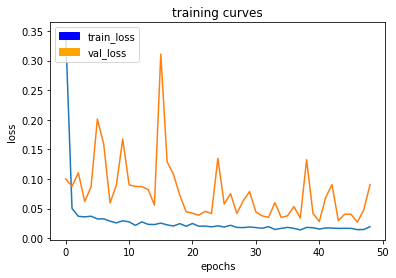

50/50 [==============================] - 40s - loss: 0.0193 - val_loss: 0.0902
Epoch 50/200
49/50 [============================>.] - ETA: 0s - loss: 0.0170

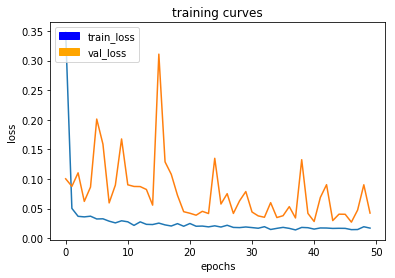

50/50 [==============================] - 40s - loss: 0.0171 - val_loss: 0.0424
Epoch 51/200
49/50 [============================>.] - ETA: 0s - loss: 0.0132

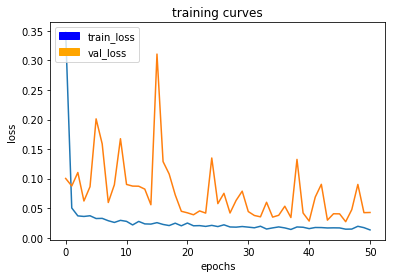

50/50 [==============================] - 41s - loss: 0.0132 - val_loss: 0.0427
Epoch 52/200
49/50 [============================>.] - ETA: 0s - loss: 0.0151

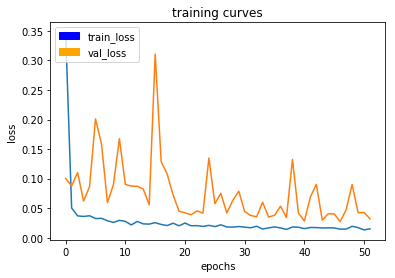

50/50 [==============================] - 40s - loss: 0.0152 - val_loss: 0.0320
Epoch 53/200
49/50 [============================>.] - ETA: 0s - loss: 0.0153

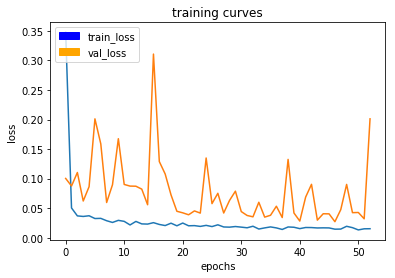

50/50 [==============================] - 40s - loss: 0.0152 - val_loss: 0.2012
Epoch 54/200
49/50 [============================>.] - ETA: 0s - loss: 0.0157

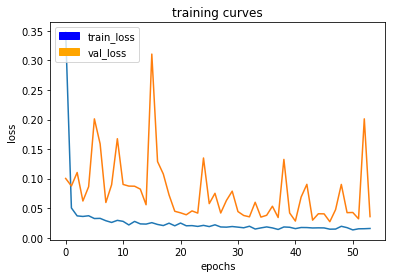

50/50 [==============================] - 41s - loss: 0.0156 - val_loss: 0.0357
Epoch 55/200
49/50 [============================>.] - ETA: 0s - loss: 0.0136

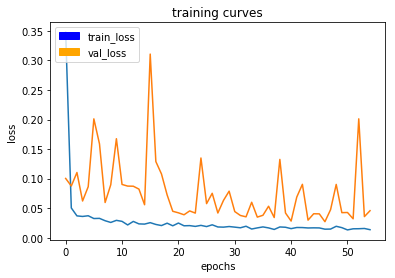

50/50 [==============================] - 40s - loss: 0.0136 - val_loss: 0.0457
Epoch 56/200
49/50 [============================>.] - ETA: 0s - loss: 0.0151

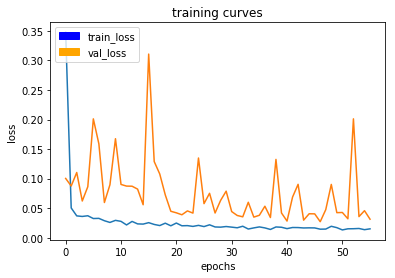

50/50 [==============================] - 40s - loss: 0.0150 - val_loss: 0.0313
Epoch 57/200
49/50 [============================>.] - ETA: 0s - loss: 0.0128

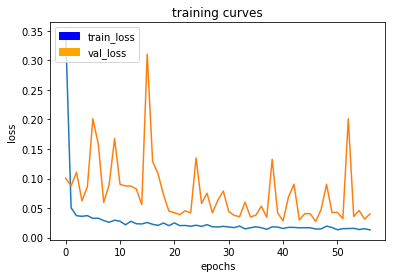

50/50 [==============================] - 40s - loss: 0.0129 - val_loss: 0.0399
Epoch 58/200
49/50 [============================>.] - ETA: 0s - loss: 0.0122

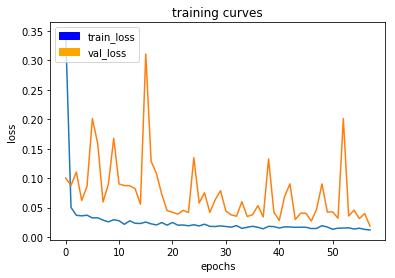

50/50 [==============================] - 40s - loss: 0.0121 - val_loss: 0.0185
Epoch 59/200
49/50 [============================>.] - ETA: 0s - loss: 0.0161

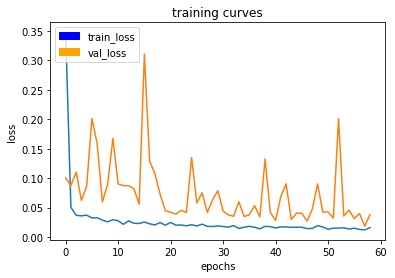

50/50 [==============================] - 41s - loss: 0.0161 - val_loss: 0.0381
Epoch 60/200
49/50 [============================>.] - ETA: 0s - loss: 0.0137

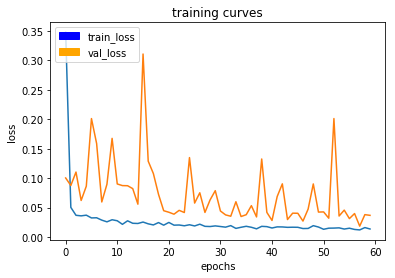

50/50 [==============================] - 40s - loss: 0.0136 - val_loss: 0.0369
Epoch 61/200
49/50 [============================>.] - ETA: 0s - loss: 0.0160

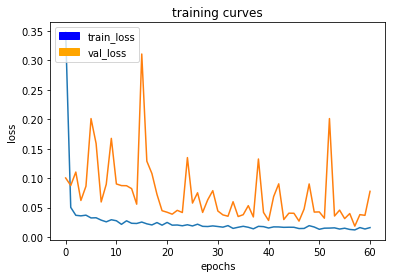

50/50 [==============================] - 40s - loss: 0.0160 - val_loss: 0.0777
Epoch 62/200
49/50 [============================>.] - ETA: 0s - loss: 0.0128

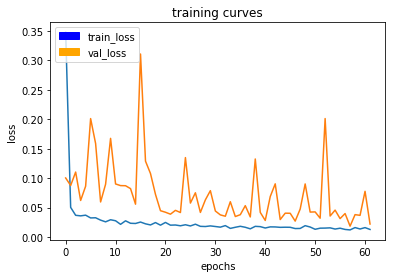

50/50 [==============================] - 40s - loss: 0.0129 - val_loss: 0.0221
Epoch 63/200
49/50 [============================>.] - ETA: 0s - loss: 0.0118

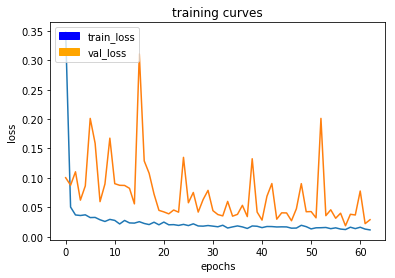

50/50 [==============================] - 40s - loss: 0.0118 - val_loss: 0.0288
Epoch 64/200
49/50 [============================>.] - ETA: 0s - loss: 0.0142

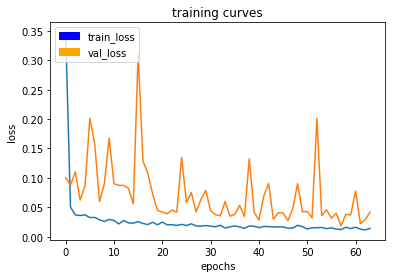

50/50 [==============================] - 40s - loss: 0.0141 - val_loss: 0.0415
Epoch 65/200
49/50 [============================>.] - ETA: 0s - loss: 0.0108

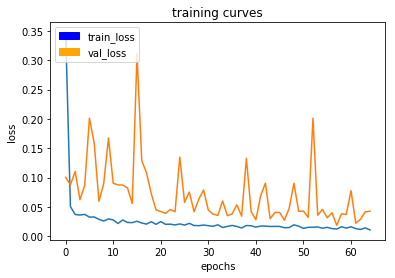

50/50 [==============================] - 40s - loss: 0.0108 - val_loss: 0.0426
Epoch 66/200
49/50 [============================>.] - ETA: 0s - loss: 0.0125

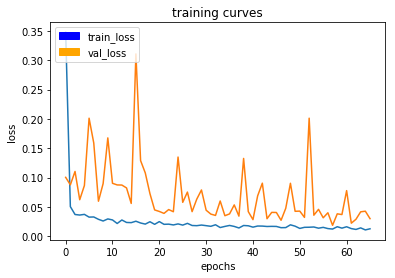

50/50 [==============================] - 40s - loss: 0.0126 - val_loss: 0.0298
Epoch 67/200
49/50 [============================>.] - ETA: 0s - loss: 0.0119

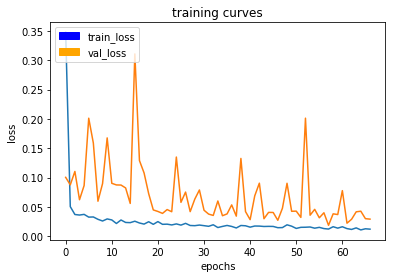

50/50 [==============================] - 40s - loss: 0.0119 - val_loss: 0.0291
Epoch 68/200
49/50 [============================>.] - ETA: 0s - loss: 0.0120

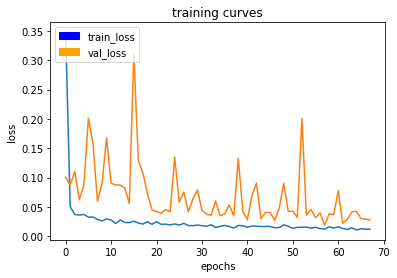

50/50 [==============================] - 40s - loss: 0.0119 - val_loss: 0.0279
Epoch 69/200
49/50 [============================>.] - ETA: 0s - loss: 0.0141

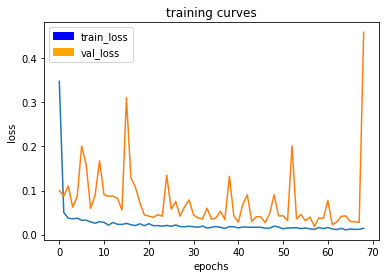

50/50 [==============================] - 40s - loss: 0.0144 - val_loss: 0.4593
Epoch 70/200
49/50 [============================>.] - ETA: 0s - loss: 0.0155

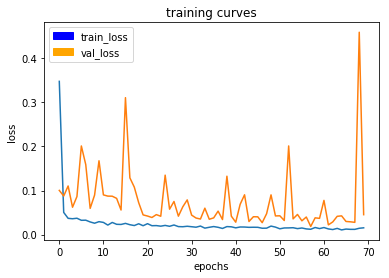

50/50 [==============================] - 40s - loss: 0.0154 - val_loss: 0.0452
Epoch 71/200
49/50 [============================>.] - ETA: 0s - loss: 0.0123

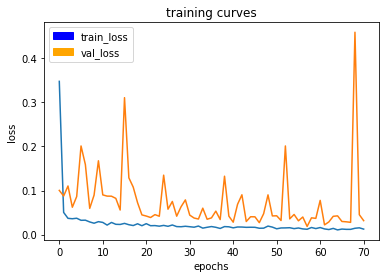

50/50 [==============================] - 40s - loss: 0.0123 - val_loss: 0.0317
Epoch 72/200
49/50 [============================>.] - ETA: 0s - loss: 0.0120

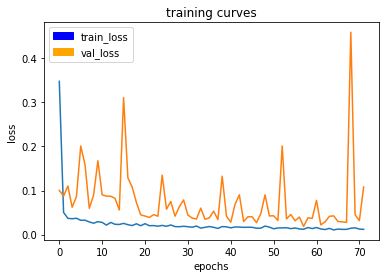

50/50 [==============================] - 40s - loss: 0.0120 - val_loss: 0.1080
Epoch 73/200
49/50 [============================>.] - ETA: 0s - loss: 0.0144

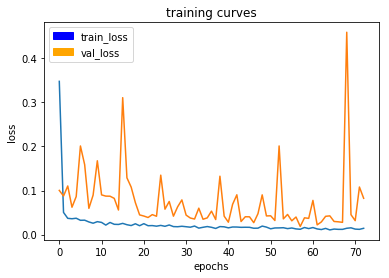

50/50 [==============================] - 40s - loss: 0.0144 - val_loss: 0.0824
Epoch 74/200
49/50 [============================>.] - ETA: 0s - loss: 0.0147

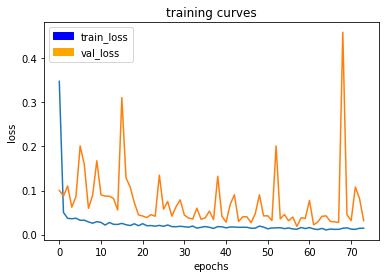

50/50 [==============================] - 40s - loss: 0.0146 - val_loss: 0.0317
Epoch 75/200
49/50 [============================>.] - ETA: 0s - loss: 0.0118

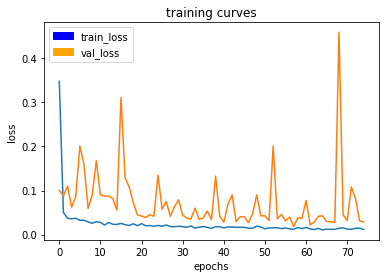

50/50 [==============================] - 40s - loss: 0.0119 - val_loss: 0.0286
Epoch 76/200
49/50 [============================>.] - ETA: 0s - loss: 0.0114

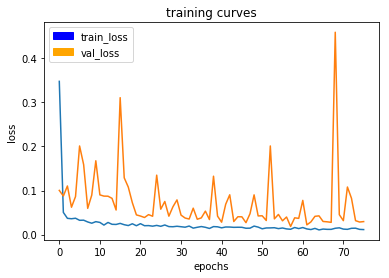

50/50 [==============================] - 40s - loss: 0.0113 - val_loss: 0.0296
Epoch 77/200
49/50 [============================>.] - ETA: 0s - loss: 0.0129

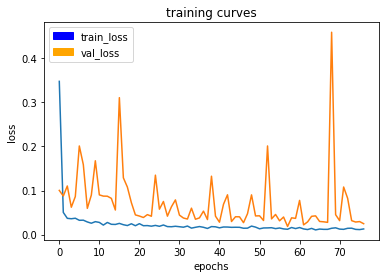

50/50 [==============================] - 40s - loss: 0.0129 - val_loss: 0.0248
Epoch 78/200
49/50 [============================>.] - ETA: 0s - loss: 0.0121

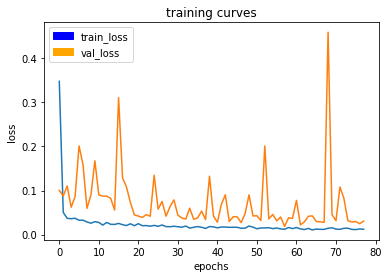

50/50 [==============================] - 40s - loss: 0.0123 - val_loss: 0.0308
Epoch 79/200
49/50 [============================>.] - ETA: 0s - loss: 0.0121

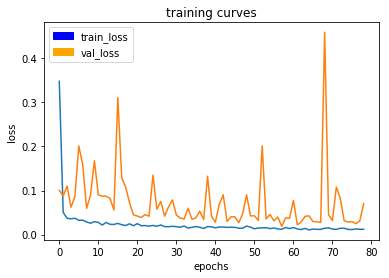

50/50 [==============================] - 41s - loss: 0.0121 - val_loss: 0.0703
Epoch 80/200
49/50 [============================>.] - ETA: 0s - loss: 0.0118

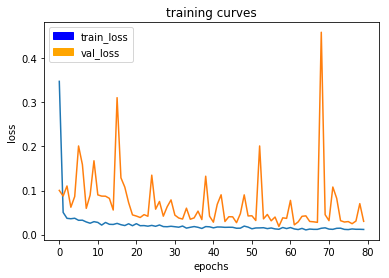

50/50 [==============================] - 41s - loss: 0.0117 - val_loss: 0.0301
Epoch 81/200
49/50 [============================>.] - ETA: 0s - loss: 0.0113

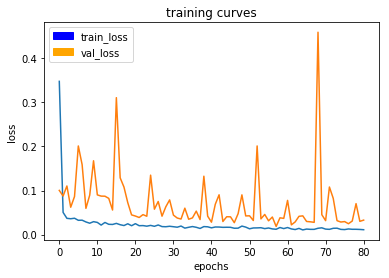

50/50 [==============================] - 40s - loss: 0.0112 - val_loss: 0.0329
Epoch 82/200
49/50 [============================>.] - ETA: 0s - loss: 0.0105

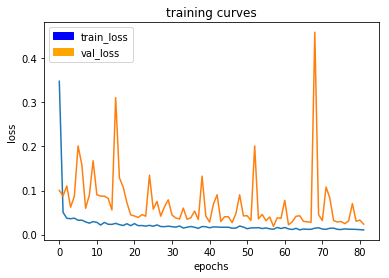

50/50 [==============================] - 41s - loss: 0.0105 - val_loss: 0.0235
Epoch 83/200
49/50 [============================>.] - ETA: 0s - loss: 0.0115

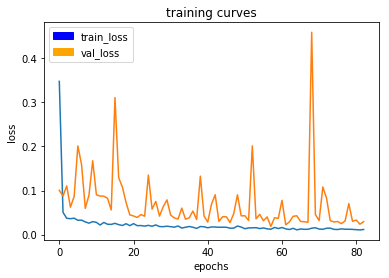

50/50 [==============================] - 40s - loss: 0.0115 - val_loss: 0.0293
Epoch 84/200
49/50 [============================>.] - ETA: 0s - loss: 0.0114

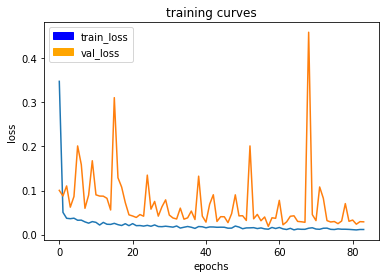

50/50 [==============================] - 40s - loss: 0.0115 - val_loss: 0.0289
Epoch 85/200
49/50 [============================>.] - ETA: 0s - loss: 0.0103

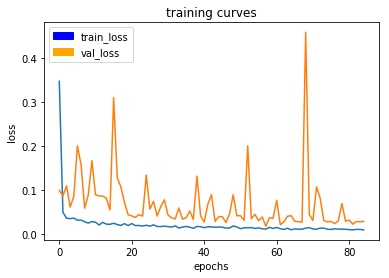

50/50 [==============================] - 40s - loss: 0.0104 - val_loss: 0.0297
Epoch 86/200
49/50 [============================>.] - ETA: 0s - loss: 0.0123

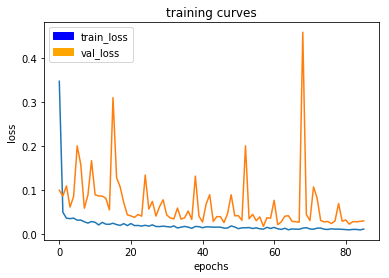

50/50 [==============================] - 40s - loss: 0.0122 - val_loss: 0.0308
Epoch 87/200
49/50 [============================>.] - ETA: 0s - loss: 0.0102

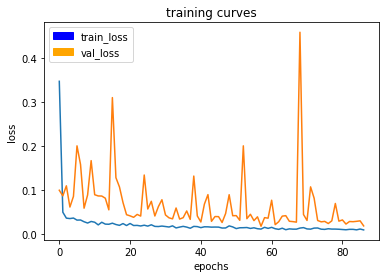

50/50 [==============================] - 40s - loss: 0.0102 - val_loss: 0.0193
Epoch 88/200
49/50 [============================>.] - ETA: 0s - loss: 0.0117

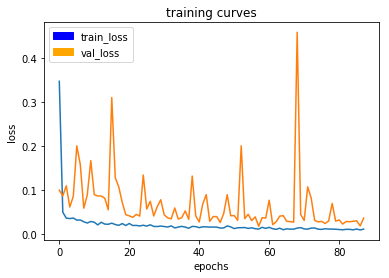

50/50 [==============================] - 40s - loss: 0.0120 - val_loss: 0.0369
Epoch 89/200
49/50 [============================>.] - ETA: 0s - loss: 0.0100

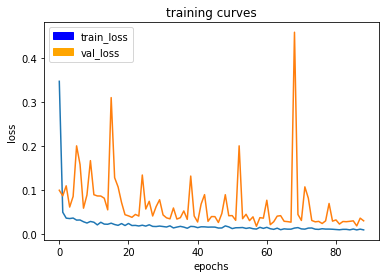

50/50 [==============================] - 40s - loss: 0.0102 - val_loss: 0.0308
Epoch 90/200
49/50 [============================>.] - ETA: 0s - loss: 0.0101

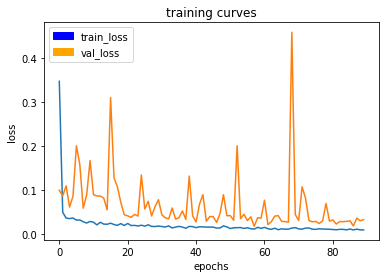

50/50 [==============================] - 40s - loss: 0.0102 - val_loss: 0.0335
Epoch 91/200
49/50 [============================>.] - ETA: 0s - loss: 0.0125

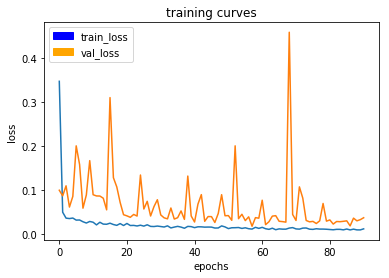

50/50 [==============================] - 40s - loss: 0.0125 - val_loss: 0.0379
Epoch 92/200
49/50 [============================>.] - ETA: 0s - loss: 0.0150

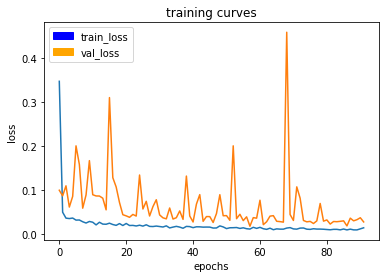

50/50 [==============================] - 40s - loss: 0.0150 - val_loss: 0.0283
Epoch 93/200
49/50 [============================>.] - ETA: 0s - loss: 0.0134

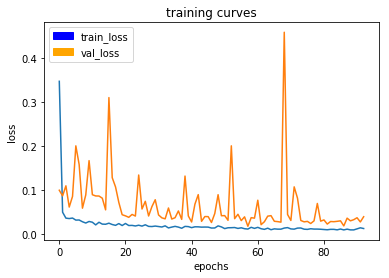

50/50 [==============================] - 40s - loss: 0.0134 - val_loss: 0.0402
Epoch 94/200
49/50 [============================>.] - ETA: 0s - loss: 0.0226

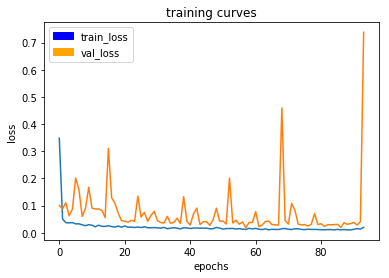

50/50 [==============================] - 40s - loss: 0.0224 - val_loss: 0.7380
Epoch 95/200
49/50 [============================>.] - ETA: 0s - loss: 0.0214

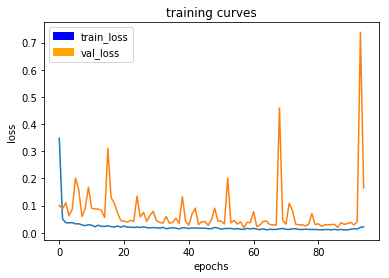

50/50 [==============================] - 40s - loss: 0.0213 - val_loss: 0.1651
Epoch 96/200
49/50 [============================>.] - ETA: 0s - loss: 0.0145

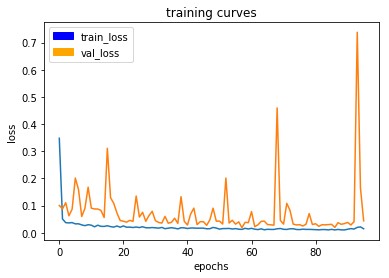

50/50 [==============================] - 40s - loss: 0.0145 - val_loss: 0.0435
Epoch 97/200
49/50 [============================>.] - ETA: 0s - loss: 0.0137

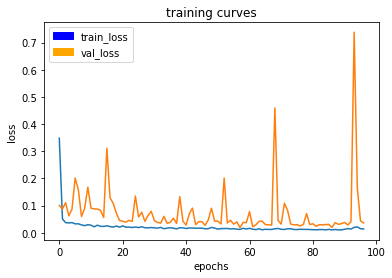

50/50 [==============================] - 40s - loss: 0.0137 - val_loss: 0.0359
Epoch 98/200
49/50 [============================>.] - ETA: 0s - loss: 0.0132

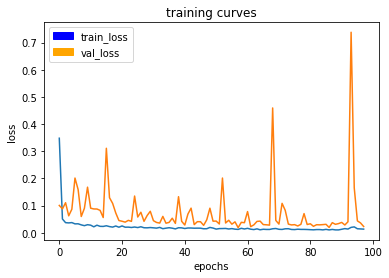

50/50 [==============================] - 41s - loss: 0.0131 - val_loss: 0.0228
Epoch 99/200
49/50 [============================>.] - ETA: 0s - loss: 0.0123

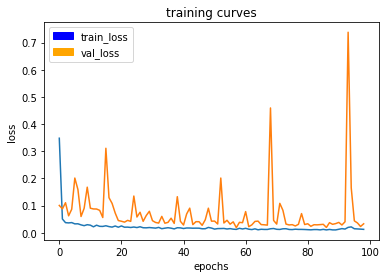

50/50 [==============================] - 40s - loss: 0.0122 - val_loss: 0.0327
Epoch 100/200
49/50 [============================>.] - ETA: 0s - loss: 0.0131

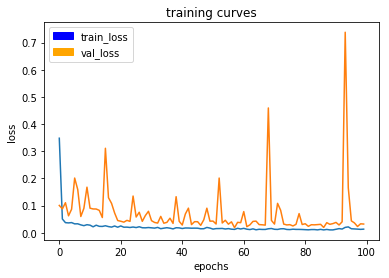

50/50 [==============================] - 41s - loss: 0.0130 - val_loss: 0.0318
Epoch 101/200
49/50 [============================>.] - ETA: 0s - loss: 0.0103

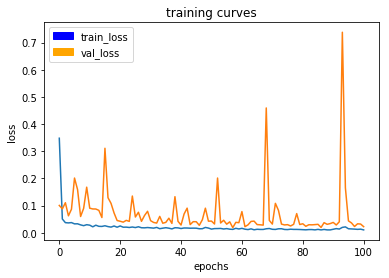

50/50 [==============================] - 41s - loss: 0.0103 - val_loss: 0.0222
Epoch 102/200
49/50 [============================>.] - ETA: 0s - loss: 0.0108

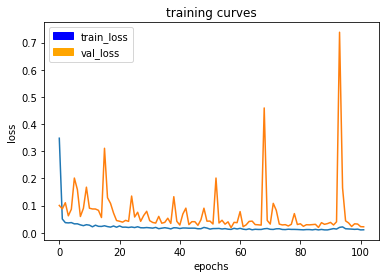

50/50 [==============================] - 40s - loss: 0.0108 - val_loss: 0.0217
Epoch 103/200
49/50 [============================>.] - ETA: 0s - loss: 0.0116

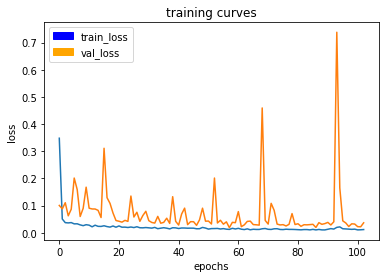

50/50 [==============================] - 40s - loss: 0.0115 - val_loss: 0.0364
Epoch 104/200
49/50 [============================>.] - ETA: 0s - loss: 0.0112

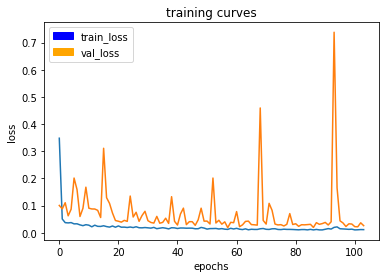

50/50 [==============================] - 40s - loss: 0.0114 - val_loss: 0.0259
Epoch 105/200
49/50 [============================>.] - ETA: 0s - loss: 0.0100

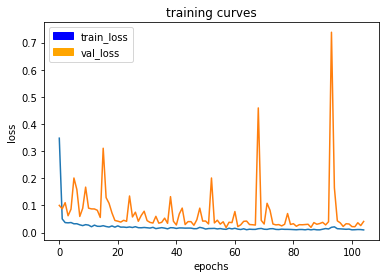

50/50 [==============================] - 40s - loss: 0.0100 - val_loss: 0.0412
Epoch 106/200
49/50 [============================>.] - ETA: 0s - loss: 0.0122

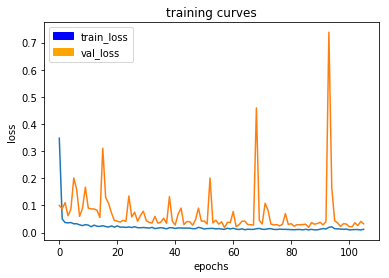

50/50 [==============================] - 41s - loss: 0.0121 - val_loss: 0.0324
Epoch 107/200
49/50 [============================>.] - ETA: 0s - loss: 0.0099

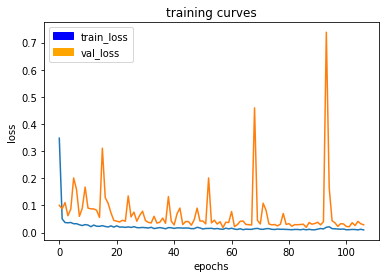

50/50 [==============================] - 40s - loss: 0.0098 - val_loss: 0.0287
Epoch 108/200
49/50 [============================>.] - ETA: 0s - loss: 0.0095

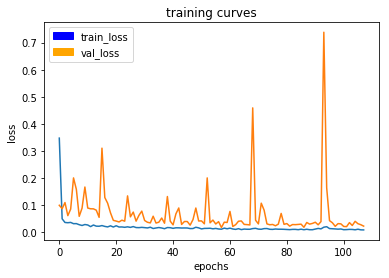

50/50 [==============================] - 41s - loss: 0.0095 - val_loss: 0.0235
Epoch 109/200
49/50 [============================>.] - ETA: 0s - loss: 0.0106

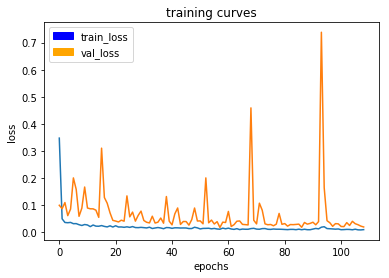

50/50 [==============================] - 40s - loss: 0.0105 - val_loss: 0.0203
Epoch 110/200
49/50 [============================>.] - ETA: 0s - loss: 0.0096

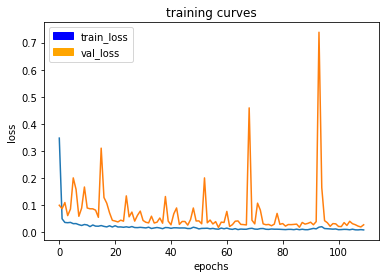

50/50 [==============================] - 40s - loss: 0.0095 - val_loss: 0.0283
Epoch 111/200
49/50 [============================>.] - ETA: 0s - loss: 0.0103

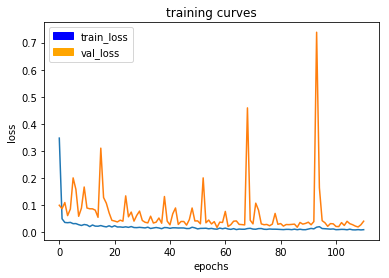

50/50 [==============================] - 41s - loss: 0.0103 - val_loss: 0.0416
Epoch 112/200
49/50 [============================>.] - ETA: 0s - loss: 0.0118

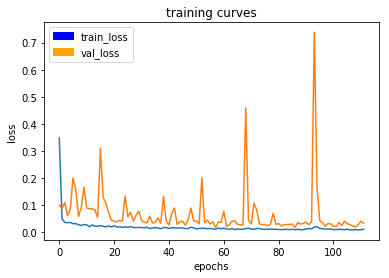

50/50 [==============================] - 40s - loss: 0.0117 - val_loss: 0.0339
Epoch 113/200
49/50 [============================>.] - ETA: 0s - loss: 0.0112

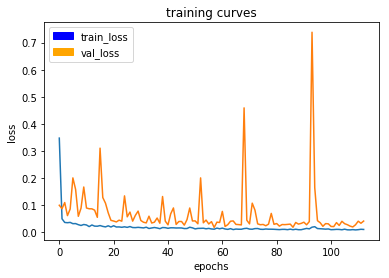

50/50 [==============================] - 41s - loss: 0.0112 - val_loss: 0.0421
Epoch 114/200
49/50 [============================>.] - ETA: 0s - loss: 0.0106

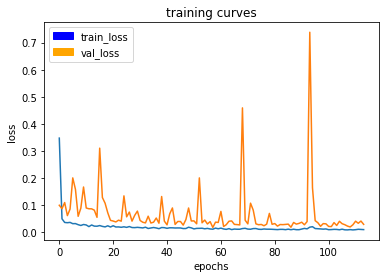

50/50 [==============================] - 40s - loss: 0.0106 - val_loss: 0.0299
Epoch 115/200
49/50 [============================>.] - ETA: 0s - loss: 0.0098

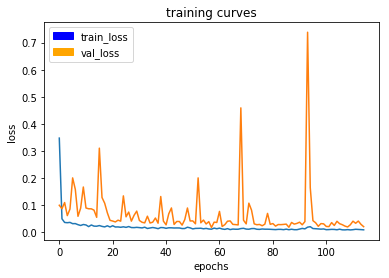

50/50 [==============================] - 40s - loss: 0.0098 - val_loss: 0.0214
Epoch 116/200
49/50 [============================>.] - ETA: 0s - loss: 0.0088

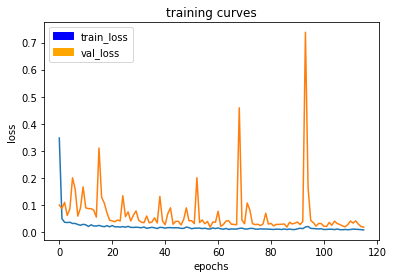

50/50 [==============================] - 40s - loss: 0.0088 - val_loss: 0.0189
Epoch 117/200
49/50 [============================>.] - ETA: 0s - loss: 0.0106

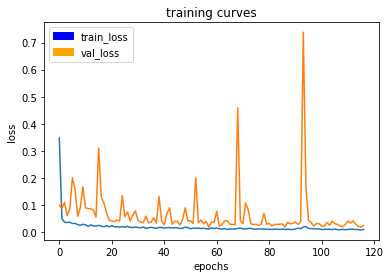

50/50 [==============================] - 40s - loss: 0.0106 - val_loss: 0.0246
Epoch 118/200
49/50 [============================>.] - ETA: 0s - loss: 0.0121

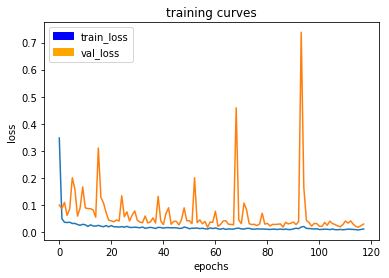

50/50 [==============================] - 41s - loss: 0.0122 - val_loss: 0.0306
Epoch 119/200
49/50 [============================>.] - ETA: 0s - loss: 0.0100

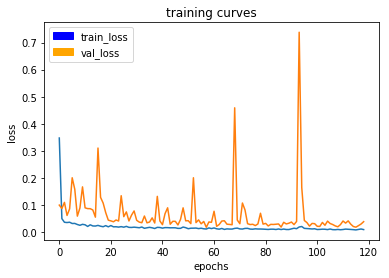

50/50 [==============================] - 40s - loss: 0.0100 - val_loss: 0.0392
Epoch 120/200
49/50 [============================>.] - ETA: 0s - loss: 0.0092

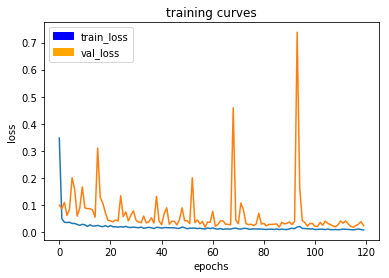

50/50 [==============================] - 40s - loss: 0.0092 - val_loss: 0.0244
Epoch 121/200
49/50 [============================>.] - ETA: 0s - loss: 0.0099

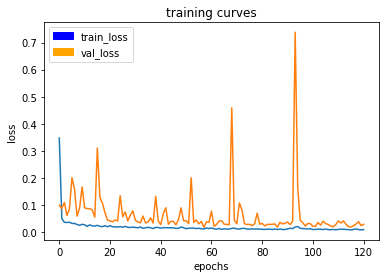

50/50 [==============================] - 41s - loss: 0.0099 - val_loss: 0.0293
Epoch 122/200
49/50 [============================>.] - ETA: 0s - loss: 0.0094

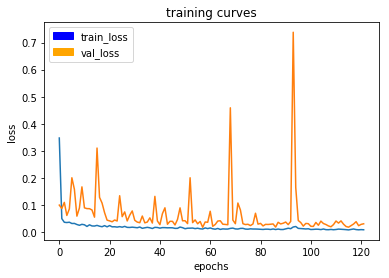

50/50 [==============================] - 40s - loss: 0.0093 - val_loss: 0.0314
Epoch 123/200
49/50 [============================>.] - ETA: 0s - loss: 0.0102

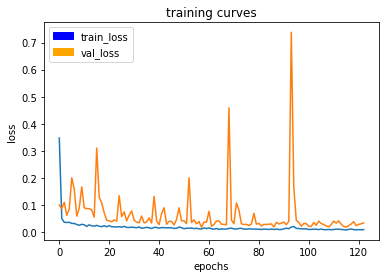

50/50 [==============================] - 40s - loss: 0.0102 - val_loss: 0.0346
Epoch 124/200
49/50 [============================>.] - ETA: 0s - loss: 0.0098

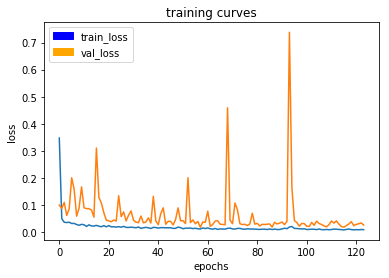

50/50 [==============================] - 40s - loss: 0.0097 - val_loss: 0.0267
Epoch 125/200
49/50 [============================>.] - ETA: 0s - loss: 0.0088

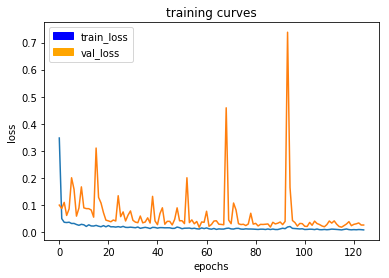

50/50 [==============================] - 40s - loss: 0.0088 - val_loss: 0.0269
Epoch 126/200
49/50 [============================>.] - ETA: 0s - loss: 0.0102

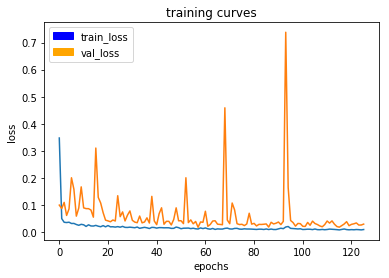

50/50 [==============================] - 41s - loss: 0.0102 - val_loss: 0.0302
Epoch 127/200
49/50 [============================>.] - ETA: 0s - loss: 0.0085

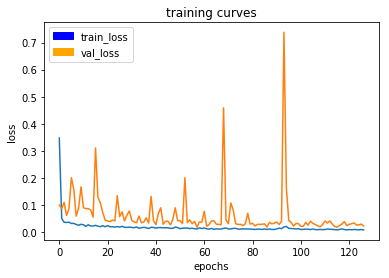

50/50 [==============================] - 40s - loss: 0.0086 - val_loss: 0.0230
Epoch 128/200
49/50 [============================>.] - ETA: 0s - loss: 0.0082

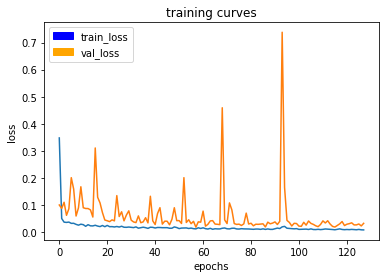

50/50 [==============================] - 40s - loss: 0.0082 - val_loss: 0.0326
Epoch 129/200
49/50 [============================>.] - ETA: 0s - loss: 0.0083

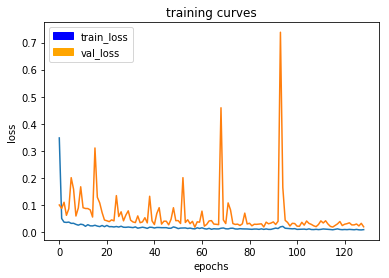

50/50 [==============================] - 40s - loss: 0.0093 - val_loss: 0.0197
Epoch 130/200
49/50 [============================>.] - ETA: 0s - loss: 0.0120

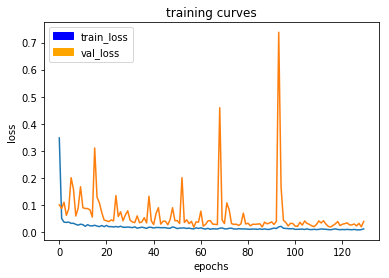

50/50 [==============================] - 40s - loss: 0.0120 - val_loss: 0.0394
Epoch 131/200
49/50 [============================>.] - ETA: 0s - loss: 0.0099

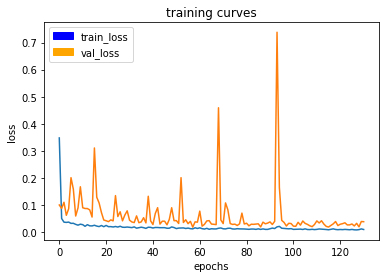

50/50 [==============================] - 40s - loss: 0.0098 - val_loss: 0.0386
Epoch 132/200
49/50 [============================>.] - ETA: 0s - loss: 0.0097

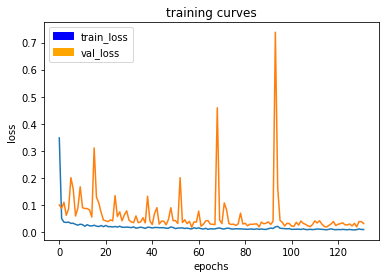

50/50 [==============================] - 40s - loss: 0.0098 - val_loss: 0.0319
Epoch 133/200
49/50 [============================>.] - ETA: 0s - loss: 0.0097

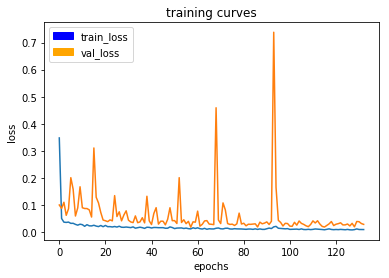

50/50 [==============================] - 40s - loss: 0.0096 - val_loss: 0.0288
Epoch 134/200
49/50 [============================>.] - ETA: 0s - loss: 0.0090

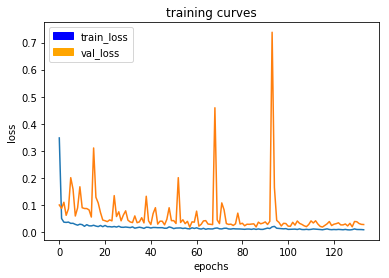

50/50 [==============================] - 41s - loss: 0.0089 - val_loss: 0.0282
Epoch 135/200
49/50 [============================>.] - ETA: 0s - loss: 0.0084

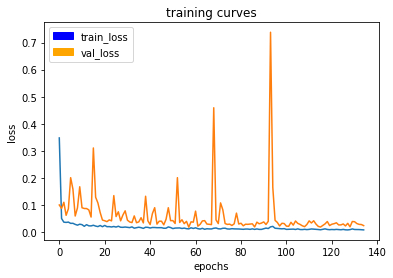

50/50 [==============================] - 40s - loss: 0.0084 - val_loss: 0.0242
Epoch 136/200
49/50 [============================>.] - ETA: 0s - loss: 0.0090

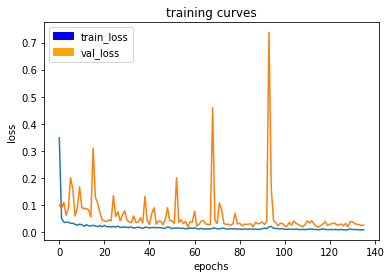

50/50 [==============================] - 40s - loss: 0.0090 - val_loss: 0.0264
Epoch 137/200
49/50 [============================>.] - ETA: 0s - loss: 0.0095

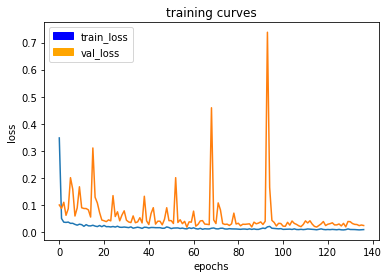

50/50 [==============================] - 40s - loss: 0.0095 - val_loss: 0.0245
Epoch 138/200
49/50 [============================>.] - ETA: 0s - loss: 0.0081

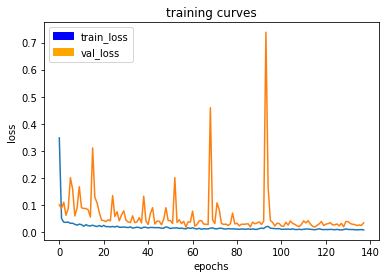

50/50 [==============================] - 40s - loss: 0.0081 - val_loss: 0.0343
Epoch 139/200
49/50 [============================>.] - ETA: 0s - loss: 0.0090

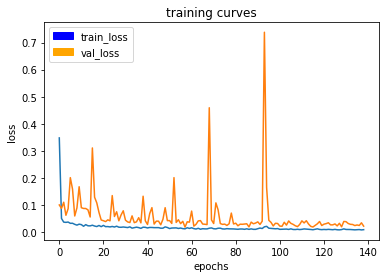

50/50 [==============================] - 41s - loss: 0.0090 - val_loss: 0.0221
Epoch 140/200
49/50 [============================>.] - ETA: 0s - loss: 0.0092

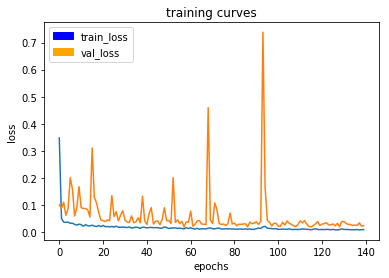

50/50 [==============================] - 41s - loss: 0.0092 - val_loss: 0.0238
Epoch 141/200
49/50 [============================>.] - ETA: 0s - loss: 0.0081

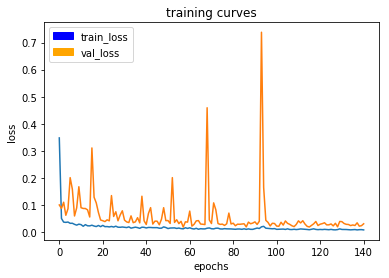

50/50 [==============================] - 40s - loss: 0.0082 - val_loss: 0.0307
Epoch 142/200
49/50 [============================>.] - ETA: 0s - loss: 0.0078

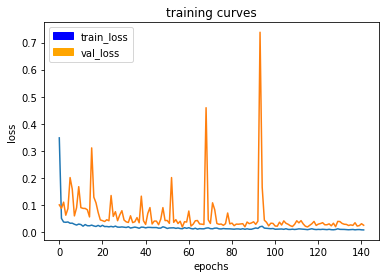

50/50 [==============================] - 40s - loss: 0.0078 - val_loss: 0.0251
Epoch 143/200
49/50 [============================>.] - ETA: 0s - loss: 0.0106

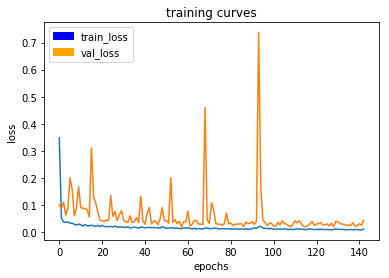

50/50 [==============================] - 40s - loss: 0.0107 - val_loss: 0.0438
Epoch 144/200
49/50 [============================>.] - ETA: 0s - loss: 0.0095

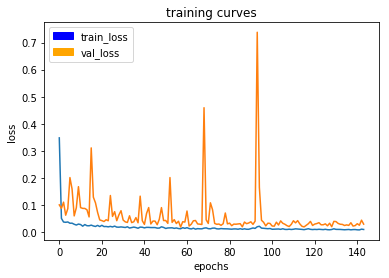

50/50 [==============================] - 40s - loss: 0.0094 - val_loss: 0.0292
Epoch 145/200
49/50 [============================>.] - ETA: 0s - loss: 0.0119

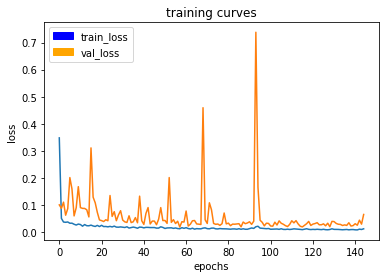

50/50 [==============================] - 40s - loss: 0.0119 - val_loss: 0.0648
Epoch 146/200
49/50 [============================>.] - ETA: 0s - loss: 0.0093

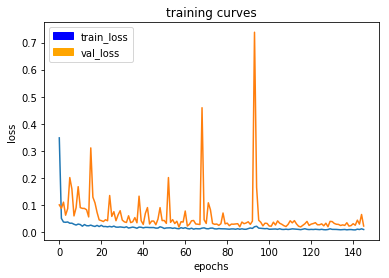

50/50 [==============================] - 40s - loss: 0.0093 - val_loss: 0.0222
Epoch 147/200
49/50 [============================>.] - ETA: 0s - loss: 0.0112

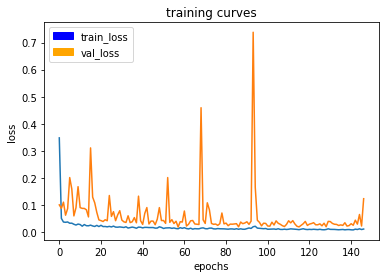

50/50 [==============================] - 40s - loss: 0.0111 - val_loss: 0.1231
Epoch 148/200
49/50 [============================>.] - ETA: 0s - loss: 0.0086

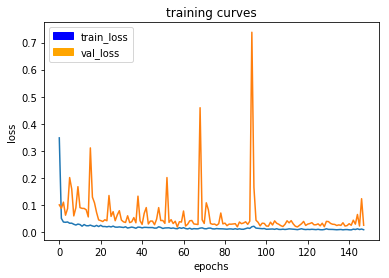

50/50 [==============================] - 41s - loss: 0.0086 - val_loss: 0.0251
Epoch 149/200
49/50 [============================>.] - ETA: 0s - loss: 0.0093

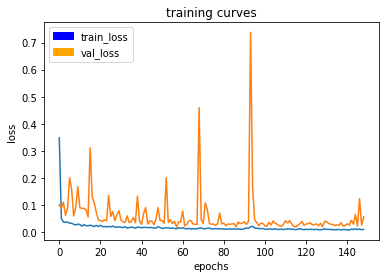

50/50 [==============================] - 40s - loss: 0.0095 - val_loss: 0.0563
Epoch 150/200
49/50 [============================>.] - ETA: 0s - loss: 0.0123

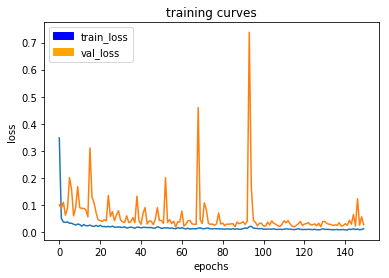

50/50 [==============================] - 40s - loss: 0.0122 - val_loss: 0.0273
Epoch 151/200
49/50 [============================>.] - ETA: 0s - loss: 0.0125

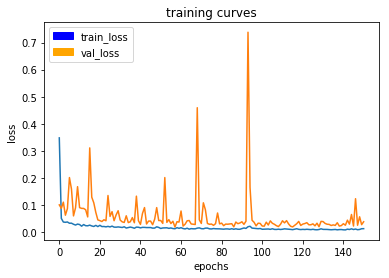

50/50 [==============================] - 40s - loss: 0.0124 - val_loss: 0.0380
Epoch 152/200
49/50 [============================>.] - ETA: 0s - loss: 0.0122

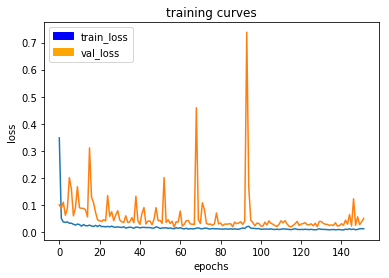

50/50 [==============================] - 40s - loss: 0.0121 - val_loss: 0.0502
Epoch 153/200
49/50 [============================>.] - ETA: 0s - loss: 0.0102

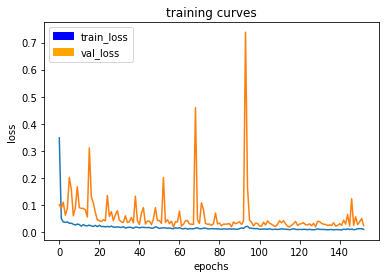

50/50 [==============================] - 40s - loss: 0.0102 - val_loss: 0.0239
Epoch 154/200
49/50 [============================>.] - ETA: 0s - loss: 0.0110

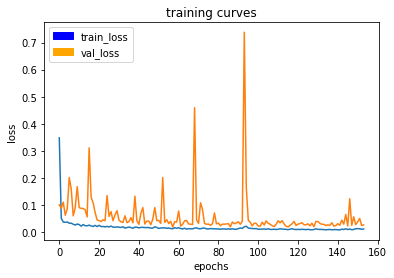

50/50 [==============================] - 40s - loss: 0.0114 - val_loss: 0.0262
Epoch 155/200
49/50 [============================>.] - ETA: 0s - loss: 0.0095

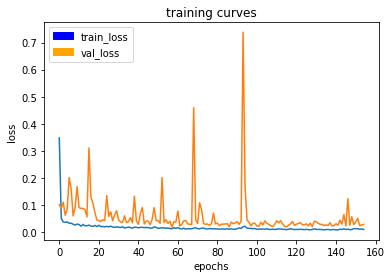

50/50 [==============================] - 40s - loss: 0.0095 - val_loss: 0.0284
Epoch 156/200
49/50 [============================>.] - ETA: 0s - loss: 0.0083

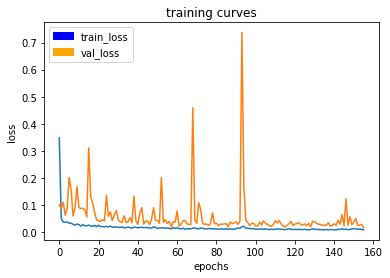

50/50 [==============================] - 40s - loss: 0.0084 - val_loss: 0.0159
Epoch 157/200
49/50 [============================>.] - ETA: 0s - loss: 0.0081

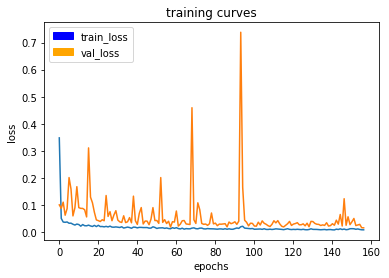

50/50 [==============================] - 41s - loss: 0.0081 - val_loss: 0.0155
Epoch 158/200
49/50 [============================>.] - ETA: 0s - loss: 0.0078

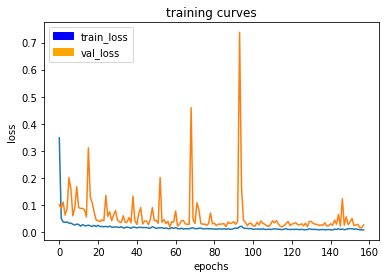

50/50 [==============================] - 41s - loss: 0.0078 - val_loss: 0.0261
Epoch 159/200
49/50 [============================>.] - ETA: 0s - loss: 0.0080

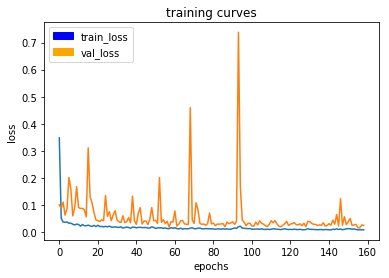

50/50 [==============================] - 40s - loss: 0.0080 - val_loss: 0.0247
Epoch 160/200
49/50 [============================>.] - ETA: 0s - loss: 0.0086

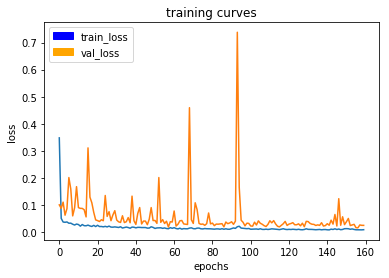

50/50 [==============================] - 41s - loss: 0.0085 - val_loss: 0.0246
Epoch 161/200
49/50 [============================>.] - ETA: 0s - loss: 0.0096

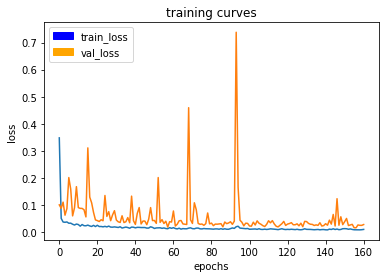

50/50 [==============================] - 40s - loss: 0.0096 - val_loss: 0.0276
Epoch 162/200
49/50 [============================>.] - ETA: 0s - loss: 0.0118

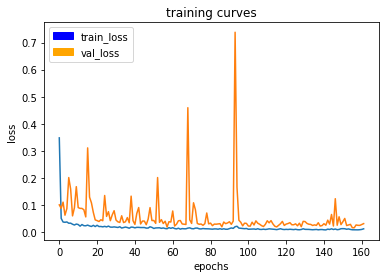

50/50 [==============================] - 40s - loss: 0.0117 - val_loss: 0.0309
Epoch 163/200
49/50 [============================>.] - ETA: 0s - loss: 0.0089

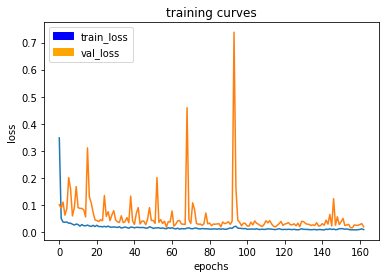

50/50 [==============================] - 41s - loss: 0.0089 - val_loss: 0.0192
Epoch 164/200
49/50 [============================>.] - ETA: 0s - loss: 0.0084

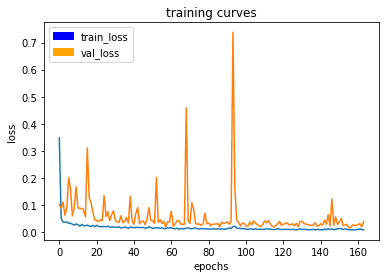

50/50 [==============================] - 40s - loss: 0.0084 - val_loss: 0.0389
Epoch 165/200
49/50 [============================>.] - ETA: 0s - loss: 0.0111

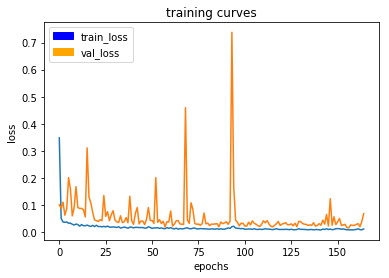

50/50 [==============================] - 40s - loss: 0.0112 - val_loss: 0.0677
Epoch 166/200
49/50 [============================>.] - ETA: 0s - loss: 0.0092

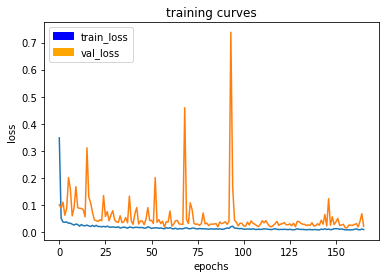

50/50 [==============================] - 40s - loss: 0.0092 - val_loss: 0.0214
Epoch 167/200
49/50 [============================>.] - ETA: 0s - loss: 0.0093

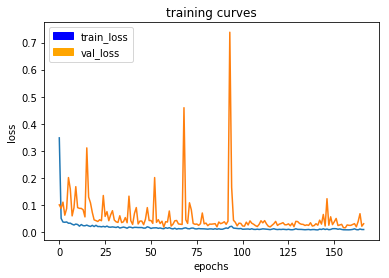

50/50 [==============================] - 40s - loss: 0.0094 - val_loss: 0.0305
Epoch 168/200
49/50 [============================>.] - ETA: 0s - loss: 0.0098

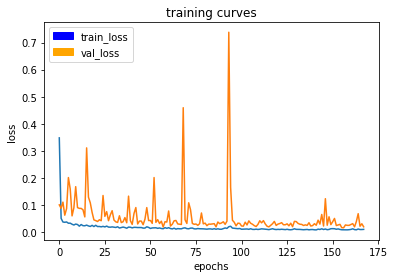

50/50 [==============================] - 40s - loss: 0.0098 - val_loss: 0.0192
Epoch 169/200
49/50 [============================>.] - ETA: 0s - loss: 0.0078

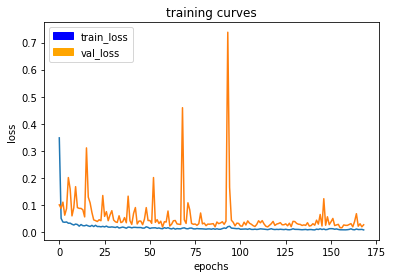

50/50 [==============================] - 40s - loss: 0.0077 - val_loss: 0.0267
Epoch 170/200
49/50 [============================>.] - ETA: 0s - loss: 0.0086

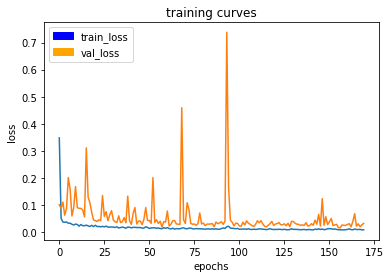

50/50 [==============================] - 41s - loss: 0.0085 - val_loss: 0.0316
Epoch 171/200
49/50 [============================>.] - ETA: 0s - loss: 0.0081

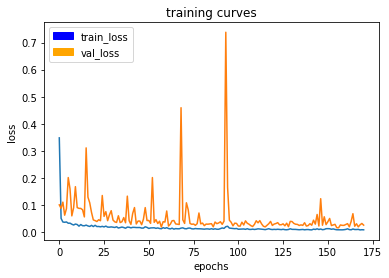

50/50 [==============================] - 40s - loss: 0.0081 - val_loss: 0.0254
Epoch 172/200
49/50 [============================>.] - ETA: 0s - loss: 0.0075

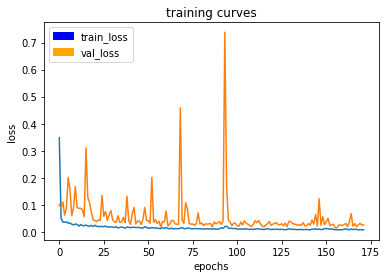

50/50 [==============================] - 40s - loss: 0.0075 - val_loss: 0.0263
Epoch 173/200
49/50 [============================>.] - ETA: 0s - loss: 0.0087

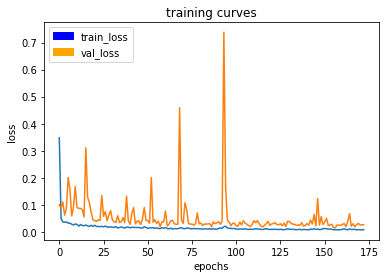

50/50 [==============================] - 41s - loss: 0.0087 - val_loss: 0.0265
Epoch 174/200
49/50 [============================>.] - ETA: 0s - loss: 0.0076

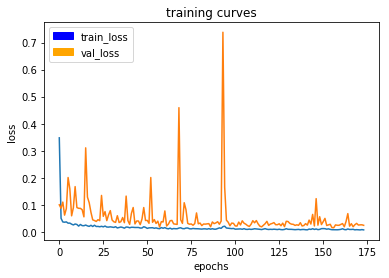

50/50 [==============================] - 41s - loss: 0.0076 - val_loss: 0.0245
Epoch 175/200
49/50 [============================>.] - ETA: 0s - loss: 0.0085

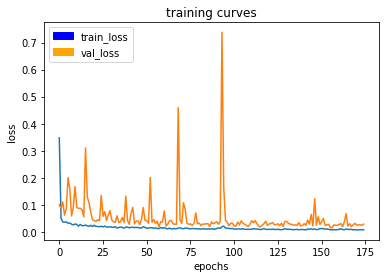

50/50 [==============================] - 40s - loss: 0.0085 - val_loss: 0.0291
Epoch 176/200
49/50 [============================>.] - ETA: 0s - loss: 0.0077

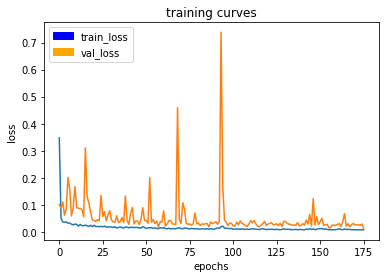

50/50 [==============================] - 41s - loss: 0.0076 - val_loss: 0.0143
Epoch 177/200
49/50 [============================>.] - ETA: 0s - loss: 0.0075

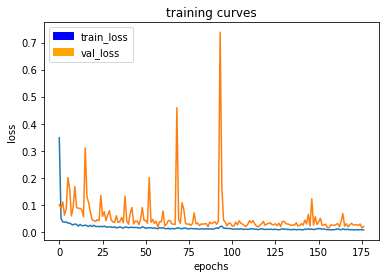

50/50 [==============================] - 40s - loss: 0.0075 - val_loss: 0.0205
Epoch 178/200
49/50 [============================>.] - ETA: 0s - loss: 0.0089

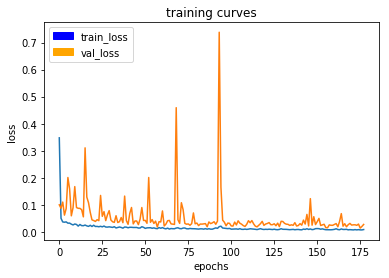

50/50 [==============================] - 40s - loss: 0.0089 - val_loss: 0.0277
Epoch 179/200
49/50 [============================>.] - ETA: 0s - loss: 0.0091

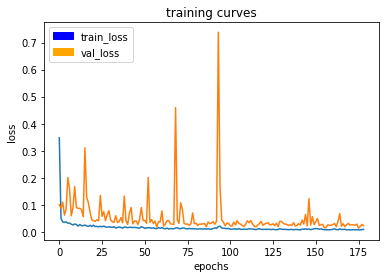

50/50 [==============================] - 41s - loss: 0.0092 - val_loss: 0.0236
Epoch 180/200
49/50 [============================>.] - ETA: 0s - loss: 0.0086

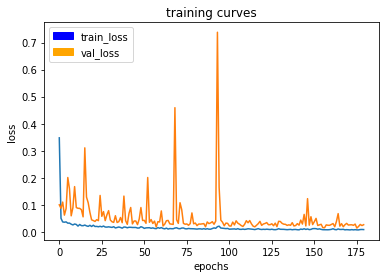

50/50 [==============================] - 40s - loss: 0.0087 - val_loss: 0.0268
Epoch 181/200
49/50 [============================>.] - ETA: 0s - loss: 0.0071

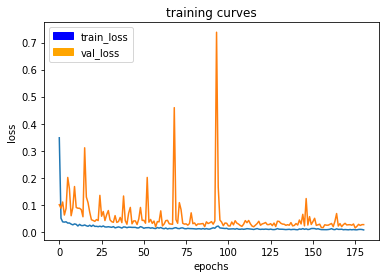

50/50 [==============================] - 41s - loss: 0.0072 - val_loss: 0.0267
Epoch 182/200
49/50 [============================>.] - ETA: 0s - loss: 0.0079

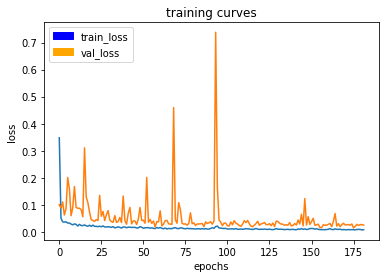

50/50 [==============================] - 40s - loss: 0.0078 - val_loss: 0.0247
Epoch 183/200
49/50 [============================>.] - ETA: 0s - loss: 0.0073

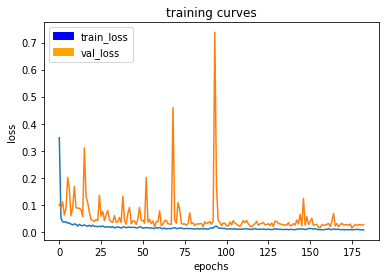

50/50 [==============================] - 41s - loss: 0.0072 - val_loss: 0.0269
Epoch 184/200
49/50 [============================>.] - ETA: 0s - loss: 0.0083

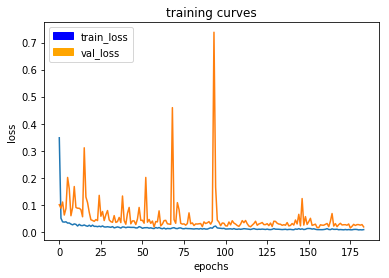

50/50 [==============================] - 40s - loss: 0.0083 - val_loss: 0.0182
Epoch 185/200
49/50 [============================>.] - ETA: 0s - loss: 0.0080

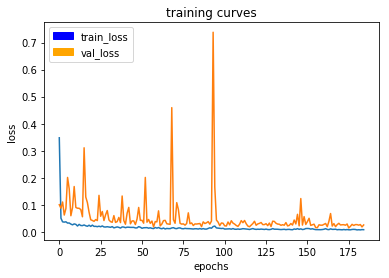

50/50 [==============================] - 40s - loss: 0.0079 - val_loss: 0.0254
Epoch 186/200
49/50 [============================>.] - ETA: 0s - loss: 0.0081

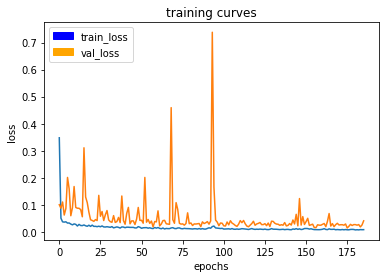

50/50 [==============================] - 41s - loss: 0.0081 - val_loss: 0.0407
Epoch 187/200
49/50 [============================>.] - ETA: 0s - loss: 0.0107

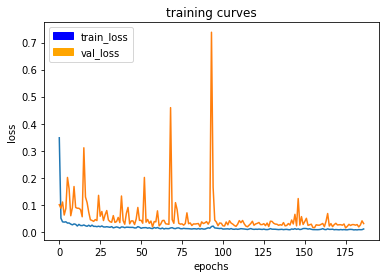

50/50 [==============================] - 41s - loss: 0.0107 - val_loss: 0.0306
Epoch 188/200
49/50 [============================>.] - ETA: 0s - loss: 0.0093

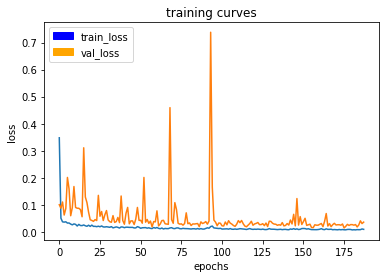

50/50 [==============================] - 40s - loss: 0.0093 - val_loss: 0.0360
Epoch 189/200
49/50 [============================>.] - ETA: 0s - loss: 0.0088

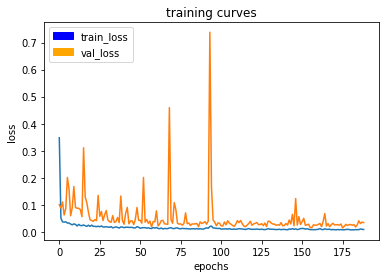

50/50 [==============================] - 41s - loss: 0.0089 - val_loss: 0.0341
Epoch 190/200
49/50 [============================>.] - ETA: 0s - loss: 0.0079

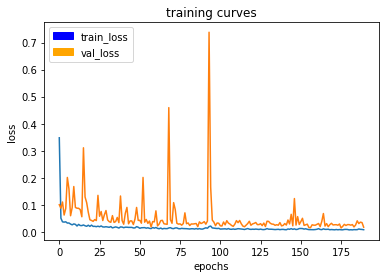

50/50 [==============================] - 40s - loss: 0.0079 - val_loss: 0.0172
Epoch 191/200
49/50 [============================>.] - ETA: 0s - loss: 0.0073

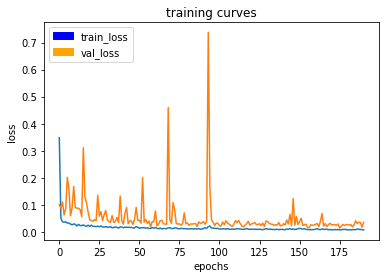

50/50 [==============================] - 41s - loss: 0.0073 - val_loss: 0.0350
Epoch 192/200
49/50 [============================>.] - ETA: 0s - loss: 0.0077

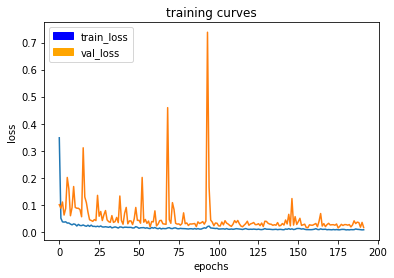

50/50 [==============================] - 41s - loss: 0.0077 - val_loss: 0.0159
Epoch 193/200
49/50 [============================>.] - ETA: 0s - loss: 0.0100

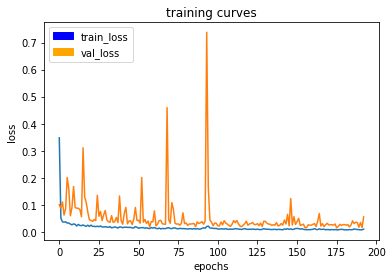

50/50 [==============================] - 40s - loss: 0.0099 - val_loss: 0.0552
Epoch 194/200
49/50 [============================>.] - ETA: 0s - loss: 0.0117

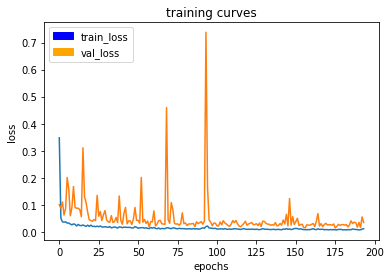

50/50 [==============================] - 41s - loss: 0.0116 - val_loss: 0.0347
Epoch 195/200
49/50 [============================>.] - ETA: 0s - loss: 0.0090

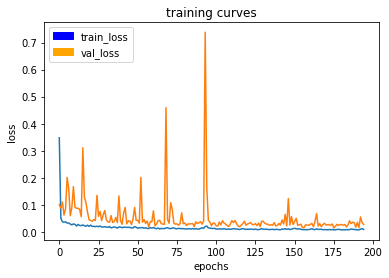

50/50 [==============================] - 40s - loss: 0.0089 - val_loss: 0.0273
Epoch 196/200
49/50 [============================>.] - ETA: 0s - loss: 0.0090

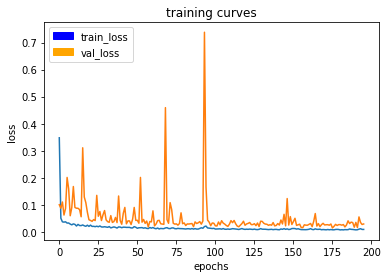

50/50 [==============================] - 40s - loss: 0.0090 - val_loss: 0.0291
Epoch 197/200
49/50 [============================>.] - ETA: 0s - loss: 0.0085

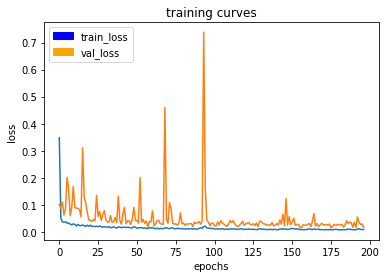

50/50 [==============================] - 40s - loss: 0.0085 - val_loss: 0.0168
Epoch 198/200
49/50 [============================>.] - ETA: 0s - loss: 0.0096

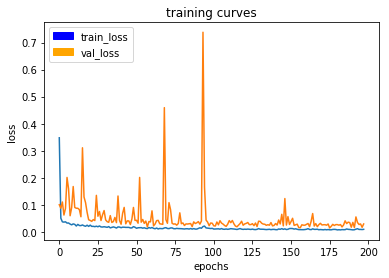

50/50 [==============================] - 40s - loss: 0.0096 - val_loss: 0.0291
Epoch 199/200
49/50 [============================>.] - ETA: 0s - loss: 0.0095

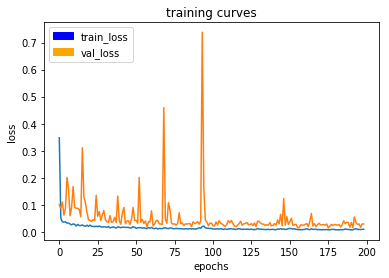

50/50 [==============================] - 41s - loss: 0.0095 - val_loss: 0.0292
Epoch 200/200
49/50 [============================>.] - ETA: 0s - loss: 0.0081

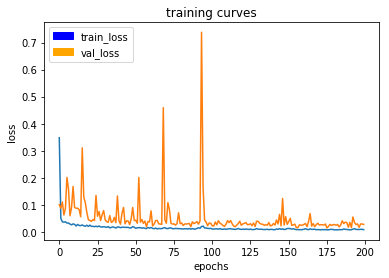

50/50 [==============================] - 40s - loss: 0.0081 - val_loss: 0.0274


In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [ ]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [18]:
model.load_weights('../data/weights/weights.0.014.hdf5')

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [19]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

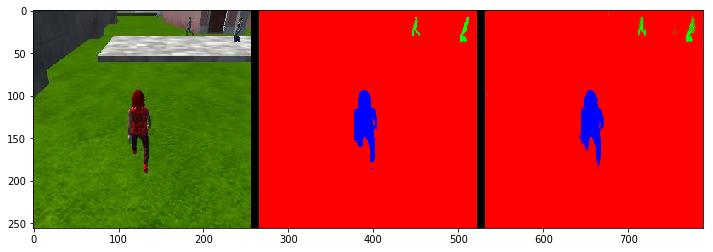

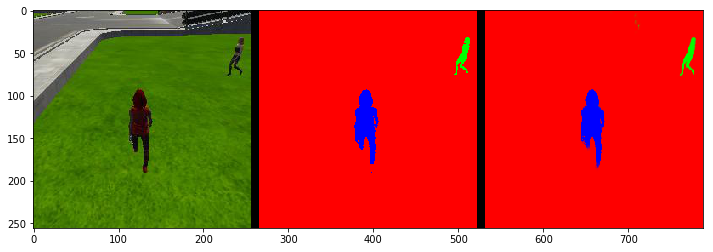

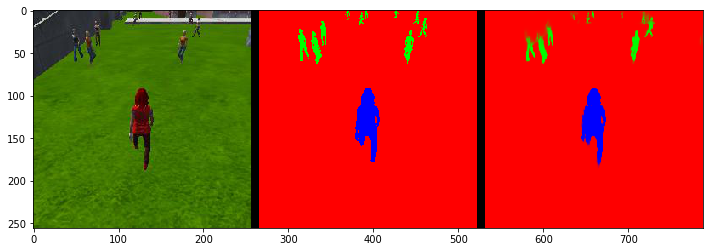

In [20]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

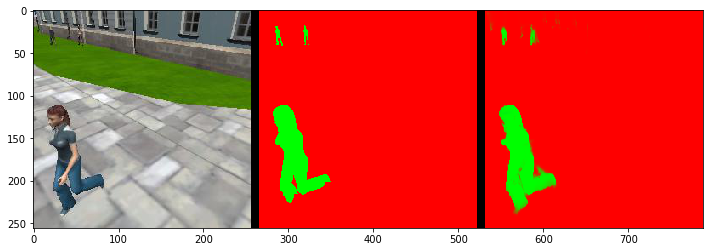

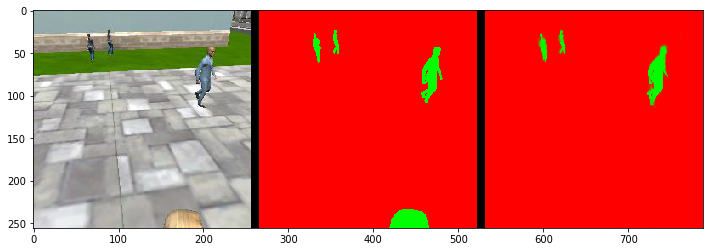

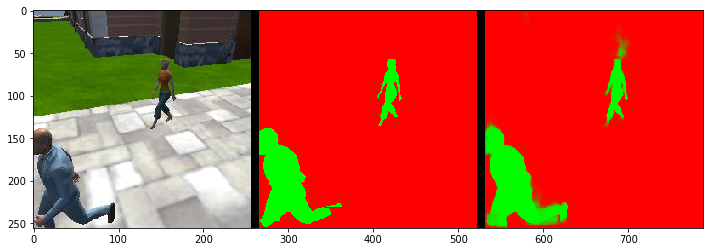

In [21]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

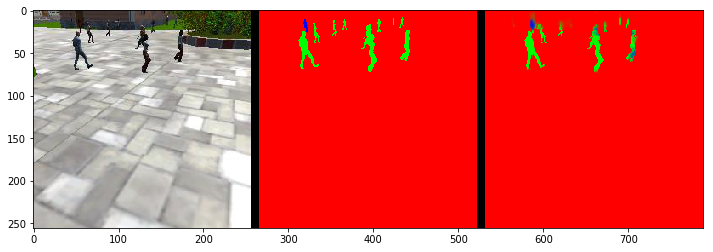

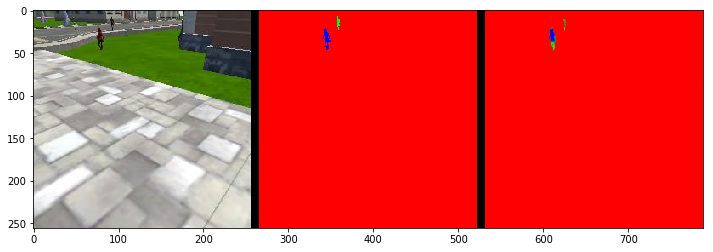

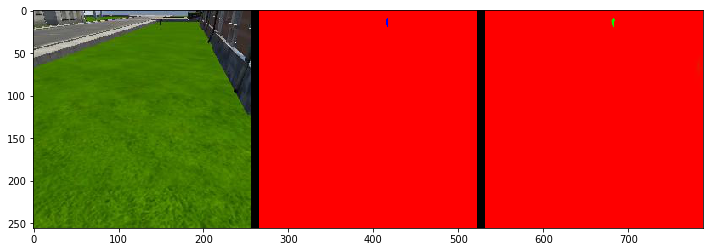

In [22]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [23]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9964811404219451
average intersection over union for other people is 0.4080489634475644
average intersection over union for the hero is 0.9431970433107918
number true positives: 539, number false positives: 0, number false negatives: 0


In [24]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.99158623879155
average intersection over union for other people is 0.8400632518512089
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 29, number false negatives: 0


In [25]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9974110184624934
average intersection over union for other people is 0.5051056169812301
average intersection over union for the hero is 0.3132321318969009
number true positives: 169, number false positives: 0, number false negatives: 143


In [26]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.8045454545454546


In [27]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.628214587604


In [28]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.505427190936
